In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

torch.set_num_threads(1)

In [3]:
path = 'logs/AdaCGP/cgp_simulated/2024-09-30/16-35-55'

# walk dir and count number of eval_results.txt files
num_files = 0
for root, dirs, files in os.walk(path):
    for file in files:
        if file == 'eval_results.txt':
            num_files += 1

print(f'Found {num_files} eval_results.txt files')

Found 20000 eval_results.txt files


## Sparsity experiment
Find the best config for RANDOM graph with 50 nodes. Use the average of the best parameters from path 1 and path 2. 

Sweep over:
- mus.0
- mus.1
- mus.2
- path 1, path 2
- alternate: true, false

And evaluate performance identifying the sparsity pattern.

In [4]:
def read_sweep_eval_results(results_dir):
    # walk the results dir
    cols = ['graph_type', 'N', 'alternate', 'use_path_1', 'gamma', 'lambda', 'nu', 'mus.0', 'mus.1', 'mus.2', 'seed']
    numeric_cols = ['N', 'gamma', 'lambda', 'nu', 'mus.0', 'mus.1', 'mus.2', 'seed']
    results_cols = ['nmse_pred_alg1', 'nmse_pred_from_h_alg1', 'nmse_w_alg1', 'pce_alg1', 'p_miss_alg1', 'p_false_alarm_alg1', \
            'nmse_pred_alg2', 'nmse_pred_from_h_alg2', 'nmse_w_alg2', 'pce_alg2', 'p_miss_alg2', 'p_false_alarm_alg2']
    all_cols = cols + results_cols
    data = {col: [] for col in all_cols}
    data['cfg_path'] = []

    # walk the results dir
    # with folders structured as in cols
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            if file == 'eval_results.txt':
                # extract the parameters
                parts = root.split('/')
                cfg_path = os.path.join(root, '.hydra', 'config.yaml')
                data['cfg_path'].append(cfg_path)
                data['seed'].append(parts[-1].split('_')[-1])
                mus_0, mus_1, mus_2 = parts[-2].split('_')[1:]
                data['mus.0'].append(mus_0)
                data['mus.1'].append(mus_1)
                data['mus.2'].append(mus_2)
                data['nu'].append(parts[-3].split('_')[-1])
                data['lambda'].append(parts[-4].split('_')[-1])
                data['gamma'].append(parts[-5].split('_')[-1])
                data['use_path_1'].append(parts[-6].split('_')[-1])
                data['alternate'].append(parts[-7].split('_')[-1])
                data['N'].append(parts[-8].split('_')[-1])
                data['graph_type'].append(parts[-9].split('_')[-1])

                subdir = root[len(results_dir)+1:]
                parts = subdir.split('/')
                if 'subdir' not in data:
                    data['subdir'] = []
                data['subdir'].append(subdir)
                
                with open(os.path.join(root, file), 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        col, result = line.split(':')
                        col = col.strip()
                        result = result.strip()
                        data[col].append(result)
    return data, (cols, numeric_cols, results_cols, all_cols)

def get_best_as_pandas(data, metric, direction, numeric_cols, results_cols):
    df = pd.DataFrame(data)
    df[results_cols] = df[results_cols].astype(float).fillna(1e10)
    df[numeric_cols] = df[numeric_cols].astype(float)
    df = df[df['N'] <= 50]
    df_best = df.groupby(by=['graph_type', 'N', 'use_path_1', 'alternate']).apply(lambda x: x.sort_values(by=metric, ascending=True if direction == 'min' else False).head(1))
    return df_best

In [5]:
# sweep_results_dir = 'logs/AdaCGP/cgp_simulated/2024-09-24/11-41-54'
sweep_results_dir = 'logs/AdaCGP/cgp_simulated/2024-09-29/09-26-17'
optimise_direction = 'min'
optimise_metric = 'nmse_pred_from_h_alg2'

data, (_, numeric_cols, results_cols, _) = read_sweep_eval_results(sweep_results_dir)

In [19]:
df_best = get_best_as_pandas(data, optimise_metric, optimise_direction, numeric_cols, results_cols)
df_best = df_best[df_best['graph_type'] == 'RANDOM']
df_best = df_best[df_best['N'] == 50]
df_best = df_best[df_best['alternate'] == 'False']
df_best = df_best[df_best['use_path_1'] == 'False']
df_best = df_best.drop(columns=['graph_type', 'N', 'use_path_1', 'alternate', 'cfg_path', 'subdir'])
df_best.mean()

/tmp/ipykernel_1466218/1523226837.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_best = df.groupby(by=['graph_type', 'N', 'use_path_1', 'alternate']).apply(lambda x: x.sort_values(by=metric, ascending=True if direction == 'min' else False).head(1))


gamma                     0.700000
lambda                    0.910000
nu                        0.005000
mus.0                     0.016371
mus.1                     0.726813
mus.2                     0.398764
seed                     42.000000
nmse_pred_alg1            0.592216
nmse_pred_from_h_alg1     0.622130
nmse_w_alg1               0.135340
pce_alg1                  1.000000
p_miss_alg1               0.000000
p_false_alarm_alg1        1.000000
nmse_pred_alg2            0.556844
nmse_pred_from_h_alg2     0.575254
nmse_w_alg2               0.054582
pce_alg2                  1.000000
p_miss_alg2               0.000000
p_false_alarm_alg2        1.000000
dtype: float64

In [20]:
# sparsity sweep results
# sparsity_sweep_path = 'logs/AdaCGP/cgp_simulated/2024-09-20/15-24-41/graph_ER/N_50'
# sparsity_sweep_path = 'logs/AdaCGP/cgp_simulated/2024-09-23/10-56-57'
# sparsity_sweep_path = 'logs/AdaCGP/cgp_simulated/2024-09-25/23-59-16'  # 26/09 best
# sparsity_sweep_path = 'logs/AdaCGP/cgp_simulated/2024-09-26/17-10-20'
# sparsity_sweep_path = 'logs/AdaCGP/cgp_simulated/2024-09-28/15-33-02'
sparsity_sweep_path = 'logs/AdaCGP/cgp_simulated/2024-09-30/16-35-55'

def read_sweep_sparsity_results(results_dir):
    # walk the results dir
    cols = ['graph_type', 'N', 'use_path_1', 'alternate', 'gamma', 'lambda', 'nu', 'mus.0', 'mus.1', 'mus.2', 'seed', 'pred_non_zero', 'true_non_zero', 'pred_non_zero_percent', 'true_non_zero_percent']
    numeric_cols = ['N', 'gamma', 'lambda', 'nu', 'mus.0', 'mus.1', 'mus.2', 'seed', 'pred_non_zero', 'true_non_zero', 'pred_non_zero_percent', 'true_non_zero_percent']
    results_cols = ['nmse_pred_alg1', 'nmse_pred_from_h_alg1', 'nmse_w_alg1', 'pce_alg1', 'p_miss_alg1', 'p_false_alarm_alg1', \
            'nmse_pred_alg2', 'nmse_pred_from_h_alg2', 'nmse_w_alg2', 'pce_alg2', 'p_miss_alg2', 'p_false_alarm_alg2']
    all_cols = cols + results_cols
    data = {col: [] for col in all_cols}
    data['cfg_path'] = []

    # walk the results dir
    # with folders structured as in cols
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            if file == 'eval_results.txt':
                # extract the parameters
                parts = root.split('/')
                
                cfg_path = os.path.join(root, '.hydra', 'config.yaml')
                data['cfg_path'].append(cfg_path)
                data['seed'].append(parts[-1].split('_')[-1])
                mus_0, mus_1, mus_2 = parts[-2].split('_')[1:]
                data['mus.0'].append(mus_0)
                data['mus.1'].append(mus_1)
                data['mus.2'].append(mus_2)
                data['nu'].append(parts[-3].split('_')[-1])
                data['lambda'].append(parts[-4].split('_')[-1])
                data['gamma'].append(parts[-5].split('_')[-1])
                data['alternate'].append(parts[-6].split('_')[-1])
                data['use_path_1'].append(parts[-7].split('_')[-1])
                data['N'].append(parts[-8].split('_')[-1])
                data['graph_type'].append(parts[-9].split('_')[-1])

                subdir = root[len(results_dir)+1:]
                parts = subdir.split('/')
                if 'subdir' not in data:
                    data['subdir'] = []
                data['subdir'].append(subdir)

                with open(os.path.join(root, file), 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        col, result = line.split(':')
                        col = col.strip()
                        result = result.strip()
                        data[col].append(result)
                
            if file == 'results.pkl':
                with open(os.path.join(root, file), 'rb') as f:
                    results = pickle.load(f)
                
                pred_W = results['matrices'][-1]
                W = results['weight_matrix']

                # compute the sparsity
                pred_non_zero = np.count_nonzero(pred_W)
                true_non_zero = np.count_nonzero(W)
                pred_non_zero_percent = pred_non_zero / (pred_W.shape[0] * pred_W.shape[1])
                true_non_zero_percent = true_non_zero / (W.shape[0] * W.shape[1])

                data['pred_non_zero'].append(pred_non_zero)
                data['true_non_zero'].append(true_non_zero)
                data['pred_non_zero_percent'].append(pred_non_zero_percent)
                data['true_non_zero_percent'].append(true_non_zero_percent)

    return data, (cols, numeric_cols, results_cols, all_cols)

def walk_sweep_dirs(sweep_dir):
    results = {}
    for root, dirs, files in os.walk(sweep_dir):
        for file in files:
            if file == 'eval_results.txt':
                subdir = root[len(sweep_dir)+1:]
                parts = subdir.split('/')
                if 'subdir' not in results:
                    results['subdir'] = []
                results['subdir'].append(subdir)
                for part in parts:
                    subparts = part.split('_')
                    value = subparts[-1]
                    key = '_'.join(subparts[:-1])
                    if key == '':
                        key = 'seed'
                    if key not in results:
                        results[key] = []
                    results[key].append(value)

                with open(os.path.join(root, file), 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        col, result = line.split(':')
                        col = col.strip()
                        result = result.strip()
                        result = float(result)
                        if col not in results:
                            results[col] = []
                        results[col].append(result)

    df = pd.DataFrame(results)
    return df

def split_by_algorithm(df):

    # get columns ending in 'alg1' and 'alg2' into two dfs
    cols = df.columns
    alg1_cols = [col for col in cols if col.endswith('_alg1')]
    alg2_cols = [col for col in cols if col.endswith('_alg2')]
    df_alg1 = df[alg1_cols]
    df_alg2 = df[alg2_cols]

    # remove '_alg1' and '_alg2' from column names if present
    df_alg1.columns = [col.replace('_alg1', '') for col in df_alg1.columns]
    df_alg2.columns = [col.replace('_alg2', '') for col in df_alg2.columns]
    
    # add back cols from original df that are not alg1 or alg2
    missing_cols = [col for col in cols if col not in alg1_cols and col not in alg2_cols]
    df_alg1 = pd.concat([df[missing_cols], df_alg1], axis=1)
    df_alg2 = pd.concat([df[missing_cols], df_alg2], axis=1)

    # add algorithm column
    df_alg1['algorithm'] = 'alg1'
    df_alg2['algorithm'] = 'alg2'

    # merge the two dfs
    df_alg = pd.concat([df_alg1, df_alg2], ignore_index=True)
    # drop nan
    df_alg = df_alg.dropna()
    return df_alg


In [21]:

data, (_, numeric_cols, results_cols, _) = read_sweep_sparsity_results(sparsity_sweep_path)

df_all = pd.DataFrame(data)
df_all[numeric_cols] = df_all[numeric_cols].astype(float)
df_all[results_cols] = df_all[results_cols].astype(float).fillna(1e10)

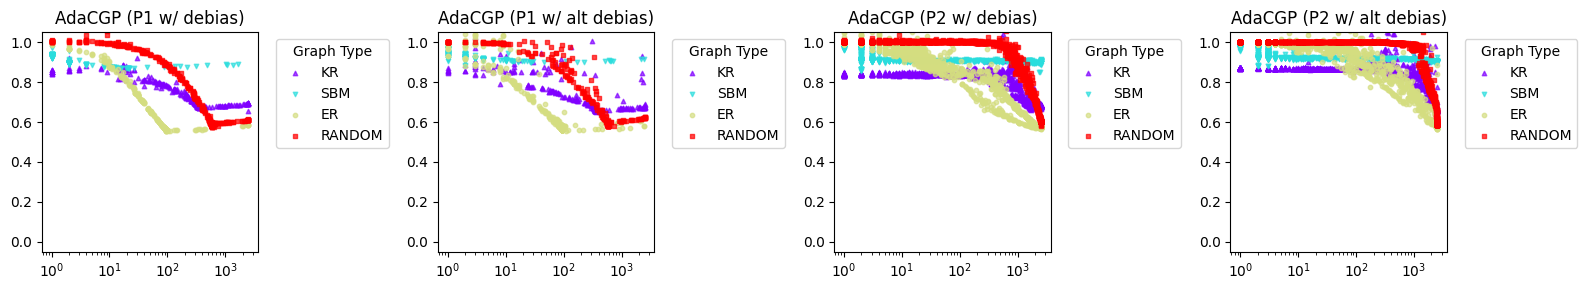

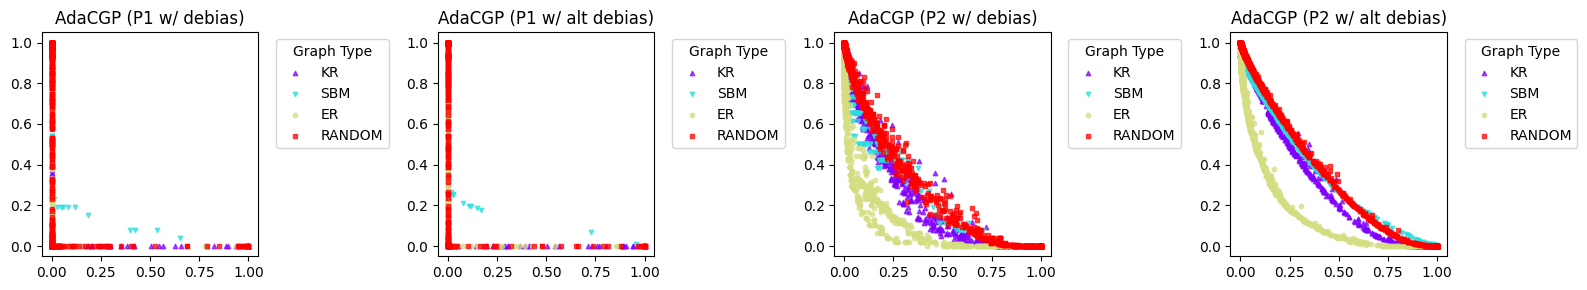

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

def set_common_labels(fig, xlabelname, ylabelname):
    pass
    # fig.text(0.5, 0, xlabelname, ha='center', va='center')
    # fig.text(0.06, 0.5, ylabelname, ha='center', va='center', rotation='vertical')

def set_axes_properties(axs, xscale=None, yscale=None):
    for ax in axs:
        if xscale:
            ax.set_xscale(xscale)
        else:
            ax.set_xlim(-0.05, 1.05)
        if yscale:
            ax.set_yscale(yscale)
        else:
            ax.set_ylim(-0.05, 1.05)

def add_colorbar(fig, ax, sc, label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label(label)

def add_polynomial_fit(ax, x, y, color, order=2):
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(mask) > order:  # Ensure we have enough valid points
        coeffs = np.polyfit(x[mask], y[mask], order)
        poly = np.poly1d(coeffs)
        x_fit = np.linspace(min(x[mask]), max(x[mask]), 100)
        y_fit = poly(x_fit)
        ax.plot(x_fit, y_fit, color=color, linestyle='-', alpha=1, linewidth=2)

def plot_adacgp_comparison(df_all, col, ycol):
    fig, axs = plt.subplots(1, 4, figsize=(16, 3))
    
    xlabelname = '# non-zero elements' if col == 'non_zero' else '% non-zero elements'
    ylabelname = {'nmse_w_alg2': 'NMSE W', 'nmse_pred_alg2': 'NMSE pred', 
                  'pce_alg2': 'PCE', 'p_miss_alg2': 'P miss', 
                  'p_false_alarm_alg2': 'P false alarm', 'nmse_pred_from_h_alg2': 'NMSE pred from h'}[ycol]
    
    set_common_labels(fig, xlabelname, ylabelname)
    set_axes_properties(axs, xscale='log')
    
    scenarios = [
        (False, True, 'AdaCGP (P1 w/ debias)'),
        (True, True, 'AdaCGP (P1 w/ alt debias)'),
        (False, False, 'AdaCGP (P2 w/ debias)'),
        (True, False, 'AdaCGP (P2 w/ alt debias)')
    ]
    
    graph_types = df_all['graph_type'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(graph_types)))
    
    for ax, (alternate, use_path_1, title) in zip(axs, scenarios):
        for graph_type, color in zip(graph_types, colors):

            if graph_type == 'SBM':
                marker_style = 'v'
            elif graph_type == 'ER':
                marker_style = 'o'
            elif graph_type == 'RANDOM':
                marker_style = 's'
            elif graph_type == 'KR':
                marker_style = '^'

            df = df_all[df_all['graph_type'] == graph_type]
            df_filtered = df[(df['alternate'] == str(alternate)) & (df['use_path_1'] == str(use_path_1))]
            x = df_filtered[f'pred_{col}']
            y = df_filtered[ycol]
            ax.scatter(x, y, c=[color], label=graph_type, alpha=0.7, s=10, marker=marker_style)
        
        ax.set_title(title)
        ax.legend(title='Graph Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'figures/AdaCGP_P1_vs_P2_nze_vs_nmsew_all_graphs.svg', bbox_inches='tight')
    plt.show()

def plot_miss_vs_false_alarm(df_all):
    fig, axs = plt.subplots(1, 4, figsize=(16, 3))
    
    set_common_labels(fig, '$P_{FA}$', '$P_M$')
    set_axes_properties(axs)
    
    scenarios = [
        (False, True, 'AdaCGP (P1 w/ debias)'),
        (True, True, 'AdaCGP (P1 w/ alt debias)'),
        (False, False, 'AdaCGP (P2 w/ debias)'),
        (True, False, 'AdaCGP (P2 w/ alt debias)')
    ]
    
    graph_types = df_all['graph_type'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(graph_types)))
    
    for ax, (alternate, use_path_1, title) in zip(axs, scenarios):
        for graph_type, color in zip(graph_types, colors):
            if graph_type == 'SBM':
                marker_style = 'v'
            elif graph_type == 'ER':
                marker_style = 'o'
            elif graph_type == 'RANDOM':
                marker_style = 's'
            elif graph_type == 'KR':
                marker_style = '^'
    
            df = df_all[df_all['graph_type'] == graph_type]
            df_filtered = df[(df['alternate'] == str(alternate)) & (df['use_path_1'] == str(use_path_1))]
            x = df_filtered['p_false_alarm_alg2']
            y = df_filtered['p_miss_alg2']
            ax.scatter(x, y, c=[color], label=graph_type, alpha=0.7, s=10, marker=marker_style)
        
        ax.set_title(title)
        ax.legend(title='Graph Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('figures/AdaCGP_P1_vs_P2_miss_vs_fa_sparsity_all_graphs.svg', bbox_inches='tight')
    plt.show()

def make_sparsity_figures_graphs(df_all):
    plot_adacgp_comparison(df_all, 'non_zero', 'nmse_pred_from_h_alg2')
    plot_miss_vs_false_alarm(df_all)

make_sparsity_figures_graphs(df_all)

/tmp/ipykernel_1466218/2617335311.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_blue = plt.cm.get_cmap('Blues')
/tmp/ipykernel_1466218/2617335311.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_red = plt.cm.get_cmap('Reds')


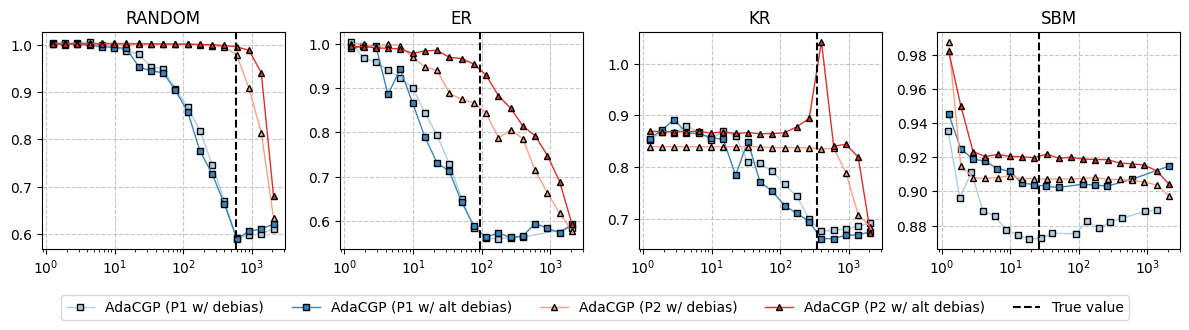

/tmp/ipykernel_1466218/2617335311.py:148: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_blue = plt.cm.get_cmap('Blues')
/tmp/ipykernel_1466218/2617335311.py:149: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_red = plt.cm.get_cmap('Reds')


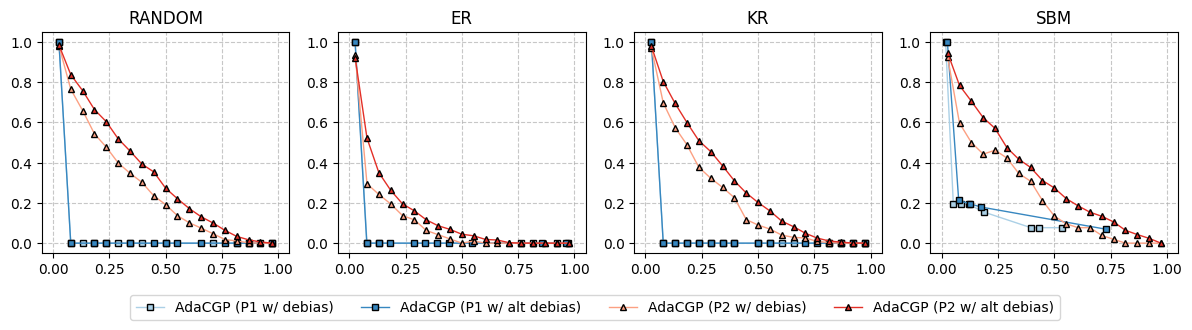

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

def set_common_labels(fig, xlabelname, ylabelname):
    pass
    # fig.text(0.5, 0, xlabelname, ha='center', va='center')
    # fig.text(0.06, 0.5, ylabelname, ha='center', va='center', rotation='vertical')

def set_axes_properties(axs, xscale=None, yscale=None):
    for ax in axs:
        if xscale:
            ax.set_xscale(xscale)
        else:
            ax.set_xlim(-0.05, 1.05)

        ax.grid(True, which='major', linestyle='--', alpha=0.7)

def add_colorbar(fig, ax, sc, label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label(label)


def plot_adacgp_comparison(df_all, col, ycol):
    graph_types = ['RANDOM', 'ER', 'KR', 'SBM']
    n_graphs = len(graph_types)
    fig, axs = plt.subplots(1, n_graphs, figsize=(3*n_graphs, 3.5), sharey=False)
    
    xlabelname = '# non-zero elements' if col == 'non_zero' else '% non-zero elements'
    ylabelname = {'nmse_w_alg2': 'NMSE W', 'nmse_pred_alg2': 'NMSE pred', 
                  'pce_alg2': 'PCE', 'p_miss_alg2': 'P miss', 
                  'p_false_alarm_alg2': 'P false alarm', 'nmse_pred_from_h_alg2': 'NMSE pred from h'}[ycol]
    
    set_common_labels(fig, xlabelname, ylabelname)
    set_axes_properties(axs, xscale='log')
    
    cmap_blue = plt.cm.get_cmap('Blues')
    cmap_red = plt.cm.get_cmap('Reds')
    scenarios = [
        (False, True, 'AdaCGP (P1 w/ debias)', 's', cmap_blue((0+10) / 90)),
        (True, True, 'AdaCGP (P1 w/ alt debias)', 's', cmap_blue((50+10) / 90)),
        (False, False, 'AdaCGP (P2 w/ debias)', '^', cmap_red((0+10) / 90)),
        (True, False, 'AdaCGP (P2 w/ alt debias)', '^', cmap_red((50+10) / 90))
    ]
    
    for ax, graph_type in zip(axs, graph_types):
        df = df_all[df_all['graph_type'] == graph_type]
        for alternate, use_path_1, label, marker_style, color in scenarios:

            df_filtered = df[(df['alternate'] == str(alternate)) & (df['use_path_1'] == str(use_path_1))]
            x = df_filtered[f'pred_{col}']
            y = df_filtered[ycol]
            ax.scatter(x, y, c=color, label=label, alpha=0.2, s=20, marker=marker_style, edgecolors='black', linewidth=0.4)
            # add_polynomial_fit(ax, x, y, color, order=)

        ax.axvline(df_filtered['true_non_zero'].iloc[0], color='black', linestyle='--', alpha=1, label='True value')
        ax.set_title(graph_type)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    # create a legend horizontally under figure center
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure)

    plt.savefig(f'figures/AdaCGP_comparison_by_graph_type_{ycol}.svg', bbox_inches='tight')
    plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

def plot_adacgp_comparison_binned(df_all, col, ycol):
    graph_types = ['RANDOM', 'ER', 'KR', 'SBM']
    n_graphs = len(graph_types)
    fig, axs = plt.subplots(1, n_graphs, figsize=(3*n_graphs, 3.5), sharey=False)
    
    xlabelname = '# non-zero elements' if col == 'non_zero' else '% non-zero elements'
    ylabelname = {'nmse_w_alg2': 'NMSE W', 'nmse_pred_alg2': 'NMSE pred', 
                  'pce_alg2': 'PCE', 'p_miss_alg2': 'P miss', 
                  'p_false_alarm_alg2': 'P false alarm', 'nmse_pred_from_h_alg2': 'NMSE pred from h'}[ycol]
    
    set_common_labels(fig, xlabelname, ylabelname)
    set_axes_properties(axs, xscale='log', yscale='log')
    
    cmap_blue = plt.cm.get_cmap('Blues')
    cmap_red = plt.cm.get_cmap('Reds')
    scenarios = [
        (False, True, 'AdaCGP (P1 w/ debias)', 's', cmap_blue((20+10) / 90)),
        (True, True, 'AdaCGP (P1 w/ alt debias)', 's', cmap_blue((50+10) / 90)),
        (False, False, 'AdaCGP (P2 w/ debias)', '^', cmap_red((20+10) / 90)),
        (True, False, 'AdaCGP (P2 w/ alt debias)', '^', cmap_red((50+10) / 90))
    ]
    
    for ax, graph_type in zip(axs, graph_types):
        df = df_all[df_all['graph_type'] == graph_type]
        for alternate, use_path_1, label, marker_style, color in scenarios:
            df_filtered = df[(df['alternate'] == str(alternate)) & (df['use_path_1'] == str(use_path_1))]
            x = df_filtered[f'pred_{col}']
            y = df_filtered[ycol]

            # Create logarithmic bins for x-axis
            bins = np.logspace(np.log10(x[x!=0].min()), np.log10(x.max()+1e-6), num=20)
            digitized = np.digitize(x, bins)

            bin_means, bin_stds, bin_centers = [], [], []
            for i in range(1, len(bins)):
                bin_data = y[digitized == i]
                if len(bin_data) > 0:
                    bin_means.append(np.median(bin_data))
                    bin_stds.append(np.std(bin_data))
                    bin_centers.append((bins[i-1] + bins[i]) / 2)
            
            # Plot binned data with error bars and lines
            if bin_centers:  # Only plot if there are valid bin centers
                # ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt=marker_style, 
                #             color=color, label=label, capsize=3, markersize=5, markeredgecolor='black', linewidth=0.2)
                # ax.plot(bin_centers, bin_means, color=color)
                ax.plot(bin_centers, bin_means, marker=marker_style, color=color, label=label, markersize=5, 
                    markeredgecolor='black', linewidth=1)

        true_non_zero = df_filtered['true_non_zero'].iloc[0] if not df_filtered.empty else None
        if true_non_zero is not None:
            ax.axvline(true_non_zero, color='black', linestyle='--', alpha=1, label='True value')
        ax.set_title(graph_type)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    # Create a legend horizontally under figure center
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure)

    plt.savefig(f'figures/AdaCGP_comparison_by_graph_type_{ycol}.svg', bbox_inches='tight')
    plt.show()

def plot_miss_vs_false_alarm(df_all):
    graph_types = ['RANDOM', 'ER', 'KR', 'SBM']
    n_graphs = len(graph_types)
    fig, axs = plt.subplots(1, n_graphs, figsize=(3*n_graphs, 3.5))
    
    set_common_labels(fig, '$P_{FA}$', '$P_M$')
    set_axes_properties(axs)
    
    cmap_blue = plt.cm.get_cmap('Blues')
    cmap_red = plt.cm.get_cmap('Reds')
    scenarios = [
        (False, True, 'AdaCGP (P1 w/ debias)', 's', cmap_blue((20+10) / 90)),
        (True, True, 'AdaCGP (P1 w/ alt debias)', 's', cmap_blue((50+10) / 90)),
        (False, False, 'AdaCGP (P2 w/ debias)', '^', cmap_red((20+10) / 90)),
        (True, False, 'AdaCGP (P2 w/ alt debias)', '^', cmap_red((50+10) / 90))
    ]
    
    for ax, graph_type in zip(axs, graph_types):
        df = df_all[df_all['graph_type'] == graph_type]
        for alternate, use_path_1, label, marker_style, color in scenarios:
            df_filtered = df[(df['alternate'] == str(alternate)) & (df['use_path_1'] == str(use_path_1))]
            if df_filtered.empty:
                continue  # Skip this scenario if no data is available

            x = df_filtered['p_false_alarm_alg2']
            y = df_filtered['p_miss_alg2']

            if x.empty or y.empty:
                continue  # Skip this scenario if x or y is empty

            bins = np.linspace(x.min(), x.max(), num=20)
            digitized = np.digitize(x, bins)

            bin_means, bin_stds, bin_centers = [], [], []
            for i in range(1, len(bins)):
                bin_data = y[digitized == i]
                if len(bin_data) > 0:
                    bin_means.append(np.median(bin_data))
                    bin_stds.append(np.percentile(bin_data, 75) - np.percentile(bin_data, 25))
                    bin_centers.append((bins[i-1] + bins[i]) / 2)
            
            # Plot binned data with error bars and lines
            if bin_centers:  # Only plot if there are valid bin centers
                ax.plot(bin_centers, bin_means, marker=marker_style, color=color, label=label, markersize=5, 
                    markeredgecolor='black', linewidth=1)

        ax.set_title(graph_type)
        # Uncomment the following lines if you want to set y-axis limits or add polynomial fit
        # ax.set_ylim(-0.05, 1.05)
        # add_polynomial_fit(ax, x, y, color, order=5)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    # Create a legend horizontally under figure center
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure)

    plt.savefig('figures/AdaCGP_miss_vs_fa_by_graph_type.svg', bbox_inches='tight', format='svg')
    plt.show()


def main(df_all):
    plot_adacgp_comparison_binned(df_all, 'non_zero', 'nmse_pred_from_h_alg2')
    plot_miss_vs_false_alarm(df_all)

main(df_all)

In [25]:
from src.graph_filters import generate_graph_filters
from src.utils import set_seed
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import RegularPolygon
import matplotlib.pyplot as plt

def format_mean_std(mean, std):
    return f"{mean:.2f} $\pm$ {std:.2f}"

def plot_triple_matrix_comparison(true_W, pred_W, fsavepath):
    fig = plt.figure(figsize=(10, 4))
    gs = fig.add_gridspec(1, 4, width_ratios=[0.1, 1, 1, 1], wspace=0.3)
    
    cax = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3])
    
    # Find global min and max for consistent color scaling
    vmin = min(true_W.min(), pred_W.min())
    vmax = max(true_W.max(), pred_W.max())
    
    # Plot true_W
    im1 = ax1.imshow(true_W, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('${W}$', fontsize=16, fontweight='bold')
    
    # Plot pred_W
    im2 = ax2.imshow(pred_W, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('${\hat{W}_{MC}}$', fontsize=16, fontweight='bold')
    
    # Create a base matrix with grey for zeros and white for true non-zeros
    true_W_binary = true_W != 0
    pred_W_binary = pred_W != 0
    base_matrix = np.where(true_W_binary, 1, 0.7)
    
    # Plot the base matrix
    ax3.imshow(base_matrix, cmap='gray', vmin=0, vmax=1)
    ax3.set_title('Non-zero elements', fontsize=16)
    
    # Initialize counters for each case
    true_positive = false_positive = false_negative = 0
    
    # Add marks for different cases
    for i in range(true_W_binary.shape[0]):
        for j in range(true_W_binary.shape[1]):
            if pred_W_binary[i, j]:
                if true_W_binary[i, j]:
                    # True positive
                    ax3.plot(j, i, 'kx', markersize=3)
                    true_positive += 1
                else:
                    # False positive
                    ax3.plot(j, i, 'b^', markersize=3, markerfacecolor='none')
                    false_positive += 1
            elif true_W_binary[i, j]:
                # False negative
                ax3.plot(j, i, 'ro', markersize=3, markerfacecolor='none')
                false_negative += 1
    
    # Remove ticks and add grid for all plots
    for ax in [ax1, ax2, ax3]:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axisbelow(True)
        ax.grid(color='black', linestyle='-', linewidth=0.5)
    
    # Add vertical colorbar on the left
    plt.colorbar(im1, cax=cax)
    
    # Add legend underneath the plot, only for cases that occur
    legend_elements = []
    if true_positive > 0:
        legend_elements.append(plt.Line2D([0], [0], marker='x', color='k', label='True Positive',
                                          markersize=6, linestyle='None'))
    if false_positive > 0:
        legend_elements.append(plt.Line2D([0], [0], marker='^', color='b', label='False Positive',
                                          markersize=6, linestyle='None', markerfacecolor='none'))
    if false_negative > 0:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='r', label='False Negative',
                                          markersize=6, markerfacecolor='none', linestyle='None'))
    
    if legend_elements:  # Only add legend if there are elements to show
        fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), bbox_to_anchor=(0.5, -0.1))
        plt.subplots_adjust(bottom=0.2)  # Make room for the legend
    
    plt.tight_layout()
    # save the figure and the legends as a .svg file
    plt.savefig(fsavepath, bbox_inches='tight')
    plt.show()

N = 50
df_adacgp = df_all.copy()

# add alternate == True rows as algorithm == 'alg3' and remove alternate column
df_alternate = df_adacgp[df_adacgp['alternate'] == 'True']
df_alternate['algorithm'] = 'alg3'
df_alternate = df_alternate.drop(columns=['alternate'])
df_adacgp = df_adacgp[df_adacgp['alternate'] == 'False']
df_adacgp = df_adacgp.drop(columns=['alternate'])
df_adacgp = pd.concat([df_adacgp, df_alternate], ignore_index=True)
df_adacgp.groupby(by=['graph_type', 'N', 'use_path_1', 'algorithm']).apply(lambda x: x.sort_values(by='nmse_pred_alg2', ascending=True).head(1))

/tmp/ipykernel_1466218/1771653013.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alternate['algorithm'] = 'alg3'
/tmp/ipykernel_1466218/1771653013.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adacgp.groupby(by=['graph_type', 'N', 'use_path_1', 'algorithm']).apply(lambda x: x.sort_values(by='nmse_pred_alg2', ascending=True).head(1))


graph_type     N use_path_1  gamma  \
graph_type N    use_path_1 algorithm                                            
ER         50.0 False      alg3      15563         ER  50.0      False   0.70   
                True       alg3      16321         ER  50.0       True   1.75   
KR         50.0 False      alg3      10220         KR  50.0      False   0.70   
                True       alg3      11368         KR  50.0       True   1.75   
RANDOM     50.0 False      alg3      17629     RANDOM  50.0      False   0.70   
                True       alg3      19583     RANDOM  50.0       True   1.75   
SBM        50.0 False      alg3      13482        SBM  50.0      False   0.70   
                True       alg3      14502        SBM  50.0       True   1.75   

                                            lambda     nu     mus.0     mus.1  \
graph_type N    use_path_1 algorithm                                            
ER         50.0 False      alg3      15563    0.91  0.005  0.008029  0.813775   
                True       alg3      16321    0.99  0.005  0.026319  0.783589   
KR         50.0 False      alg3      10220    0.91  0.005  0.003597  0.125898   
                True       alg3      11368    0.99  0.005  0.034576  0.584602   
RANDOM     50.0 False      alg3      17629    0.91  0.005  0.013953  0.151779   
                True       alg3      19583    0.99  0.005  0.031722  0.934440   
SBM        50.0 False      alg3      13482    0.91  0.005  0.013840  0.563980   
                True       alg3      14502    0.99  0.005  0.052922  0.820982   

                                               mus.2  seed  ...  \
graph_type N    use_path_1 algorithm                        ...   
ER         50.0 False      alg3      15563  0.106709  42.0  ...   
                True       alg3      16321  0.227797  42.0  ...   
KR         50.0 False      alg3      10220  0.756753  42.0  ...   
                True       alg3      11368  0.376420  42.0  ...   
RANDOM     50.0 False      alg3      17629  0.043792  42.0  ...   
                True       alg3      19583  0.148581  42.0  ...   
SBM        50.0 False      alg3      13482  0.038434  42.0  ...   
                True       alg3      14502  0.945616  42.0  ...   

                                            p_false_alarm_alg1  \
graph_type N    use_path_1 algorithm                             
ER         50.0 False      alg3      15563            1.000000   
                True       alg3      16321            0.000012   
KR         50.0 False      alg3      10220            1.000000   
                True       alg3      11368            0.007001   
RANDOM     50.0 False      alg3      17629            1.000000   
                True       alg3      19583            0.044155   
SBM        50.0 False      alg3      13482            0.999639   
                True       alg3      14502            0.000000   

                                            nmse_pred_alg2  \
graph_type N    use_path_1 algorithm                         
ER         50.0 False      alg3      15563        0.515804   
                True       alg3      16321        0.527667   
KR         50.0 False      alg3      10220        0.615113   
                True       alg3      11368        0.624164   
RANDOM     50.0 False      alg3      17629        0.534849   
                True       alg3      19583        0.544753   
SBM        50.0 False      alg3      13482        0.806235   
                True       alg3      14502        0.837922   

                                            nmse_pred_from_h_alg2  \
graph_type N    use_path_1 algorithm                                
ER         50.0 False      alg3      15563               0.570118   
                True       alg3      16321               0.557993   
KR         50.0 False      alg3      10220               0.669126   
                True       alg3      11368               0.652875   
RANDOM     50.0 False      alg3      17629            

In [26]:
df_adacgp.groupby(['graph_type', 'N', 'use_path_1', 'algorithm']).apply(lambda x: x.sort_values(by='nmse_pred_from_h_alg2', ascending=True).head(1))

/tmp/ipykernel_1466218/3390012534.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adacgp.groupby(['graph_type', 'N', 'use_path_1', 'algorithm']).apply(lambda x: x.sort_values(by='nmse_pred_from_h_alg2', ascending=True).head(1))


graph_type     N use_path_1  gamma  \
graph_type N    use_path_1 algorithm                                            
ER         50.0 False      alg3      15354         ER  50.0      False   0.70   
                True       alg3      16278         ER  50.0       True   1.75   
KR         50.0 False      alg3      10958         KR  50.0      False   0.70   
                True       alg3      11585         KR  50.0       True   1.75   
RANDOM     50.0 False      alg3      17625     RANDOM  50.0      False   0.70   
                True       alg3      19379     RANDOM  50.0       True   1.75   
SBM        50.0 False      alg3      12664        SBM  50.0      False   0.70   
                True       alg3      14502        SBM  50.0       True   1.75   

                                            lambda     nu     mus.0     mus.1  \
graph_type N    use_path_1 algorithm                                            
ER         50.0 False      alg3      15354    0.91  0.005  0.019915  0.901932   
                True       alg3      16278    0.99  0.005  0.016484  0.880106   
KR         50.0 False      alg3      10958    0.91  0.005  0.014569  0.602378   
                True       alg3      11585    0.99  0.005  0.024180  0.352367   
RANDOM     50.0 False      alg3      17625    0.91  0.005  0.013595  0.560196   
                True       alg3      19379    0.99  0.005  0.045132  0.420771   
SBM        50.0 False      alg3      12664    0.91  0.005  0.714134  0.929757   
                True       alg3      14502    0.99  0.005  0.052922  0.820982   

                                               mus.2  seed  ...  \
graph_type N    use_path_1 algorithm                        ...   
ER         50.0 False      alg3      15354  0.358330  42.0  ...   
                True       alg3      16278  0.101704  42.0  ...   
KR         50.0 False      alg3      10958  0.980800  42.0  ...   
                True       alg3      11585  0.010412  42.0  ...   
RANDOM     50.0 False      alg3      17625  0.527872  42.0  ...   
                True       alg3      19379  0.311549  42.0  ...   
SBM        50.0 False      alg3      12664  0.717454  42.0  ...   
                True       alg3      14502  0.945616  42.0  ...   

                                            p_false_alarm_alg1  \
graph_type N    use_path_1 algorithm                             
ER         50.0 False      alg3      15354            0.998166   
                True       alg3      16278            0.002966   
KR         50.0 False      alg3      10958            1.000000   
                True       alg3      11585            0.049416   
RANDOM     50.0 False      alg3      17625            1.000000   
                True       alg3      19379            0.004313   
SBM        50.0 False      alg3      12664            0.000175   
                True       alg3      14502            0.000000   

                                            nmse_pred_alg2  \
graph_type N    use_path_1 algorithm                         
ER         50.0 False      alg3      15354        0.520589   
                True       alg3      16278        0.529149   
KR         50.0 False      alg3      10958        0.619330   
                True       alg3      11585        0.658290   
RANDOM     50.0 False      alg3      17625        0.542149   
                True       alg3      19379        0.546440   
SBM        50.0 False      alg3      12664        0.930574   
                True       alg3      14502        0.837922   

                                            nmse_pred_from_h_alg2  \
graph_type N    use_path_1 algorithm                                
ER         50.0 False      alg3      15354               0.566762   
                True       alg3      16278               0.556534   
KR         50.0 False      alg3      10958               0.648379   
                True       alg3      11585               0.646863   
RANDOM     50.0 False      alg3      17625            

In [27]:
df_adacgp = df_adacgp[(df_adacgp['p_miss_alg2'] != 0.0) & (df_adacgp['p_false_alarm_alg2'] != 1.0)]

# cant be algorithm 1
df_adacgp = df_adacgp[df_adacgp['algorithm'] != 'alg1']

df_adacgp = df_adacgp[df_adacgp['p_miss_alg2'] <= 0.1]

# df_adacgp = df_adacgp[(df_adacgp['p_miss'] != 0.0) & (df_adacgp['p_miss'] != 1.0)]
# df_adacgp = df_adacgp[(df_adacgp['p_false_alarm'] != 0.0) & (df_adacgp['p_false_alarm'] != 1.0)]
df_adacgp['p_miss_inverse'] = 1 / df_adacgp['p_miss_alg2']
df_adacgp['p_miss_inverse'] = df_adacgp['p_miss_inverse'].replace(np.inf, 0)
df_adacgp['p_false_alarm_inverse'] = 1 / df_adacgp['p_false_alarm_alg2']
df_adacgp['p_false_alarm_inverse'] = df_adacgp['p_false_alarm_inverse'].replace(np.inf, 0)
df_adacgp['nmse_w_inverse'] = 1 / df_adacgp['nmse_w_alg2']
df_adacgp['nmse_w_inverse'] = df_adacgp['nmse_w_inverse'].replace(np.inf, 0)

beta = 0.
df_adacgp['custom'] = (1 + beta**2) * (df_adacgp['pce_alg2'] * df_adacgp['p_false_alarm_inverse']) / (beta**2 * df_adacgp['pce_alg2'] + df_adacgp['p_false_alarm_inverse'])
# df_adacgp['custom'] = 2 * (df_adacgp['p_miss_inverse'] * df_adacgp['p_false_alarm_inverse']) / (df_adacgp['p_miss_inverse'] + df_adacgp['p_false_alarm_inverse'])
df_adacgp['custom'] = df_adacgp['custom']

best_adacgp = df_adacgp.groupby(['graph_type', 'N']).apply(lambda x: x.sort_values(by=['nmse_pred_from_h_alg2'], ascending=[True]).head(1))
best_adacgp


/tmp/ipykernel_1466218/19235524.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_adacgp = df_adacgp.groupby(['graph_type', 'N']).apply(lambda x: x.sort_values(by=['nmse_pred_from_h_alg2'], ascending=[True]).head(1))


,,,graph_type,N,use_path_1,gamma,lambda,nu,mus.0,mus.1,mus.2,seed,...,pce_alg2,p_miss_alg2,p_false_alarm_alg2,cfg_path,subdir,algorithm,p_miss_inverse,p_false_alarm_inverse,nmse_w_inverse,custom
graph_type,N,,,,,,,,,,,,,,,,,,,,,,
ER,50.0,16841,ER,50.0,True,1.75,0.99,0.005,0.036118,0.885322,0.588364,42.0,...,0.999621,0.000379,0.000000,logs/AdaCGP/cgp_simulated/2024-09-30/16-35-55/...,graph_ER/N_50/use_path_1_True/alternate_True/g...,alg3,2638.891454,0.000000,26.892648,NaN
KR,50.0,11368,KR,50.0,True,1.75,0.99,0.005,0.034576,0.584602,0.376420,42.0,...,0.999331,0.000669,0.007001,logs/AdaCGP/cgp_simulated/2024-09-30/16-35-55/...,graph_KR/N_50/use_path_1_True/alternate_True/g...,alg3,1495.727455,142.838166,18.132456,0.999331
RANDOM,50.0,19045,RANDOM,50.0,True,1.75,0.99,0.005,0.053237,0.074011,0.969524,42.0,...,0.994701,0.005299,0.000356,logs/AdaCGP/cgp_simulated/2024-09-30/16-35-55/...,graph_RANDOM/N_50/use_path_1_True/alternate_Tr...,alg3,188.715956,2812.314563,12.857837,0.994701
SBM,50.0,3828,SBM,50.0,True,1.75,0.99,0.005,0.003117,0.789143,0.054901,42.0,...,0.923077,0.076923,0.534762,logs/AdaCGP/cgp_simulated/2024-09-30/16-35-55/...,graph_SBM/N_50/use_path_1_True/alternate_False...,NaN,13.000000,1.869992,2.357367,0.923077


/tmp/ipykernel_1466218/1771653013.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


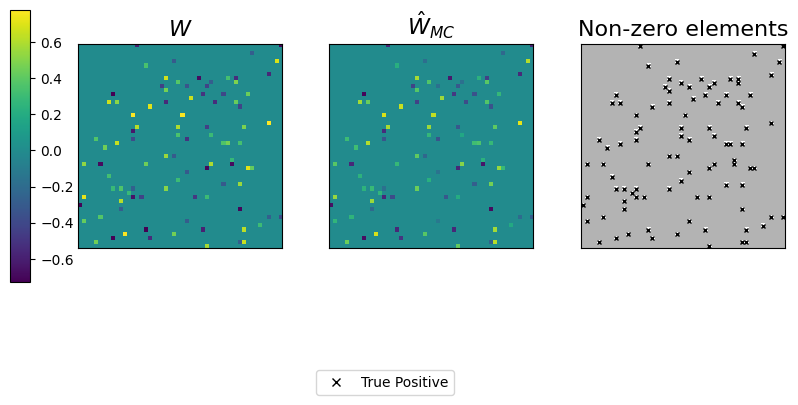

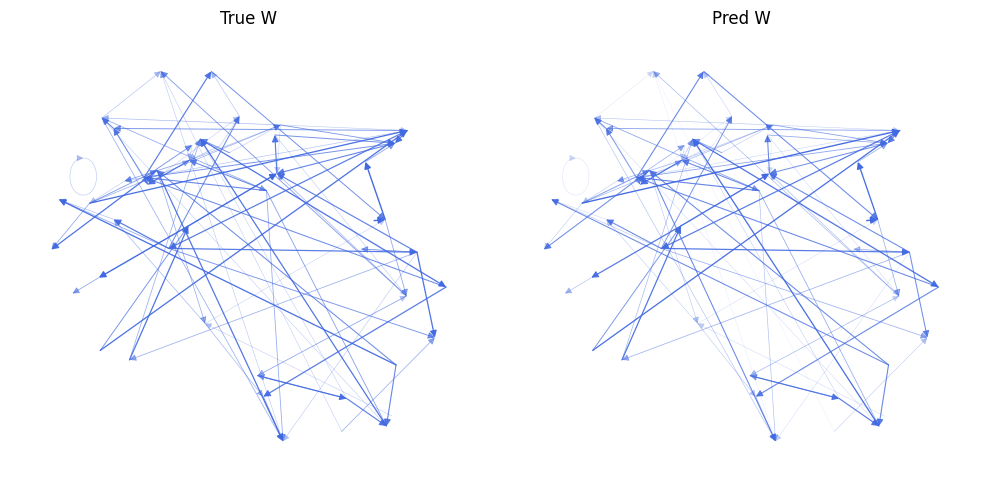

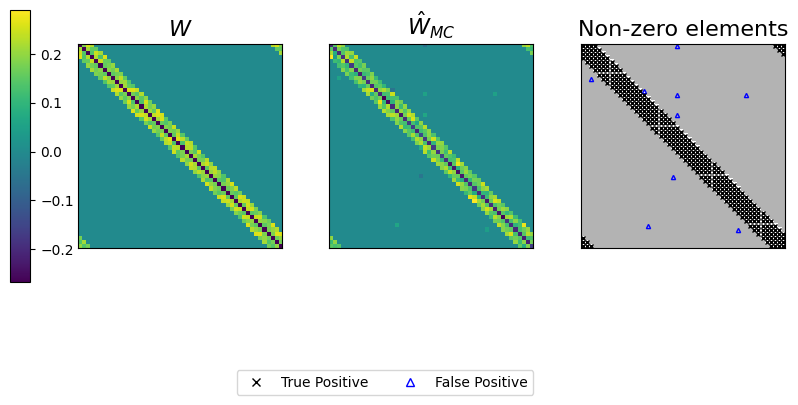

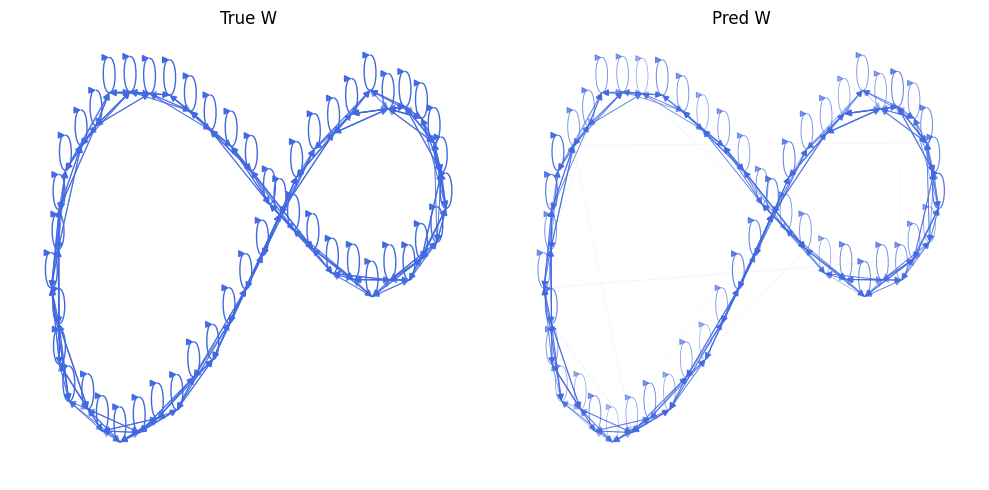

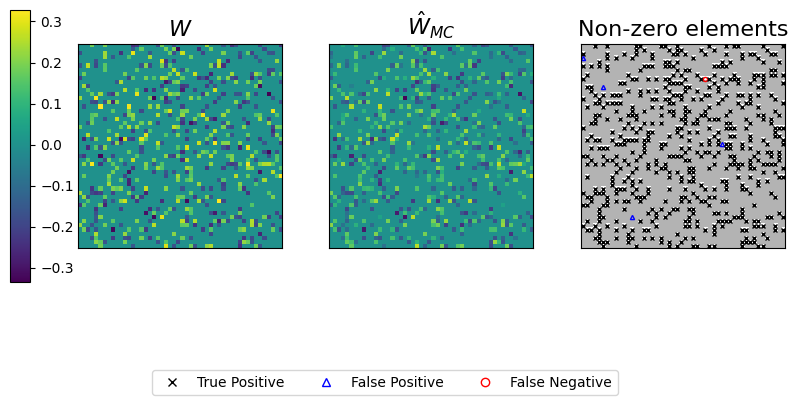

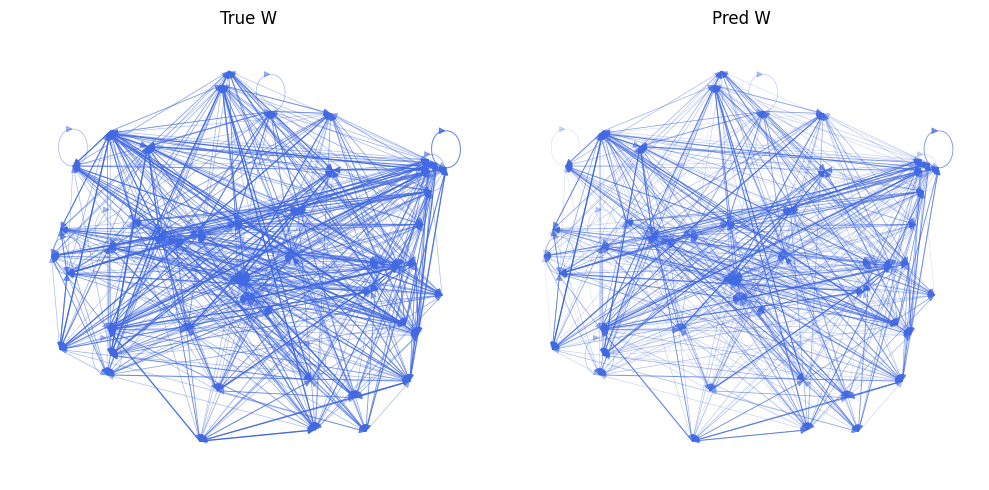

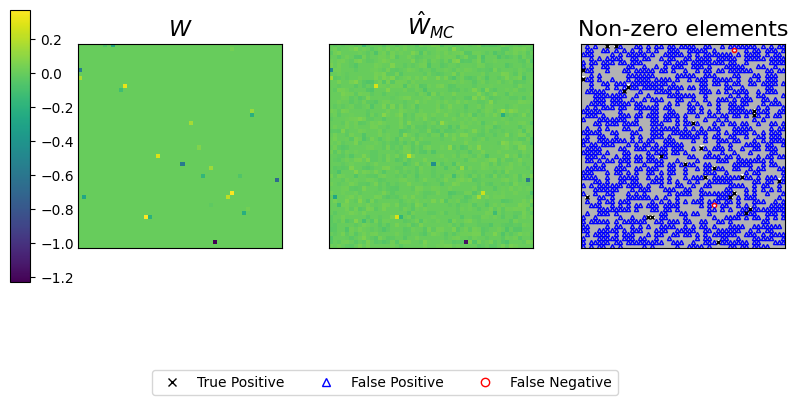

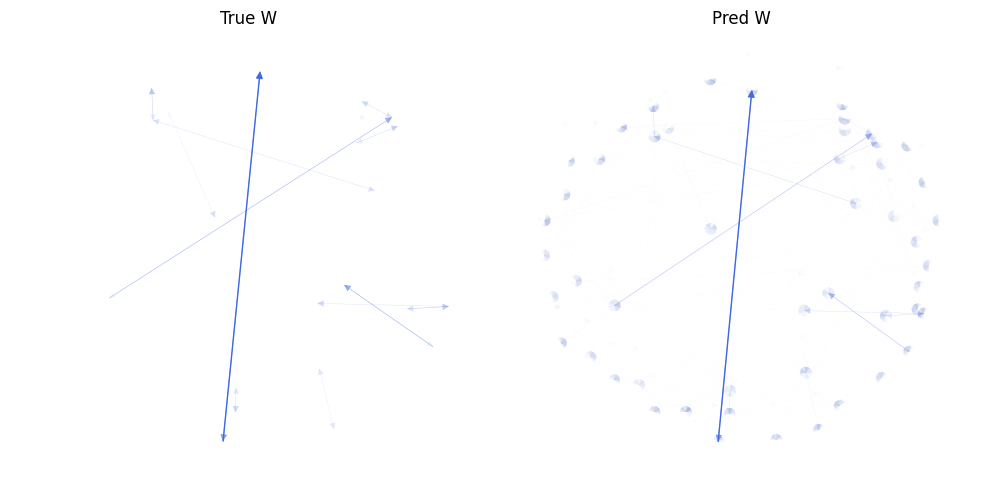

In [28]:

# remove graph_type from index
best_adacgp = best_adacgp.reset_index(level=0, drop=True)

# get index of best row
best_adacgp_index = best_adacgp.index

# get the rows corresponding to the best index
matrices = {}
for vs in best_adacgp_index.values:
    matrices[vs] = []
    df_tmp = best_adacgp.loc[vs]

    row_results_path = os.path.join(sparsity_sweep_path, df_tmp['subdir'])
    fname = 'results.pkl'
    fpath = os.path.join(row_results_path, fname)
    with open(fpath, 'rb') as f:
        results = pickle.load(f)
    
    graph_type = df_tmp['graph_type']
    N_p = int(df_tmp['N'])
    
    set_seed(42)
    _, true_W, _ = generate_graph_filters(N_p, 3, graph_type)
    first_alg_converged_status = results['first_alg_converged_status']
    t_matrix = np.argmax(first_alg_converged_status)
    pred_W = results['matrices'][-1]
    matrices[vs].append((true_W, pred_W))

from scipy.stats import mode
import matplotlib.pyplot as plt

for key in matrices.keys():
    graph = best_adacgp.loc[key]['graph_type']
    matrixs = matrices[key]
    trues = []
    preds = []
    for i, (true_W, pred_W) in enumerate(matrixs):
        trues.append(true_W)
        preds.append(pred_W)

    trues = np.array(trues)
    preds = np.array(preds)

    # most common non zero values
    most_common_nzv = np.median((preds != 0).astype(int), axis=0)
    most_common_zvs = np.median((preds == 0).astype(int), axis=0)

    mean_true = np.median(trues, axis=0)
    mean_pred = np.median(preds, axis=0)

    plot_triple_matrix_comparison(mean_true, mean_pred, 'figures/260924_matrix_%s_%s.svg' % (graph, N))

    # plot the mean_true and mean_pred matrices on a networkx spring layout
    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.from_numpy_array(mean_true, create_using=nx.DiGraph)
    pos = nx.spring_layout(G)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    ax1, ax2 = axs

    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_weights = np.array([edge_weights[(u, v)] for u, v in G.edges()])
    edge_weights = np.abs(edge_weights) / np.abs(edge_weights).max()

    # dont plot arrows
    nx.draw(G, pos, ax=ax1, with_labels=False, node_size=0, node_color='skyblue', font_color='black', font_weight='bold', edge_color='royalblue', width=edge_weights, alpha=edge_weights)
    ax1.set_title('True W')

    G = nx.from_numpy_array(mean_pred, create_using=nx.DiGraph)
    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_weights = np.array([edge_weights[(u, v)] for u, v in G.edges()])
    edge_weights = np.abs(edge_weights) / np.abs(edge_weights).max()
    nx.draw(G, pos, ax=ax2, with_labels=False, node_size=0, node_color='skyblue', font_color='black', font_weight='bold', edge_color='royalblue', width=edge_weights, alpha=edge_weights)
    ax2.set_title('Pred W')

    plt.tight_layout()
    plt.show()

# Tables and figures for paper

In [29]:
##### BEST RESULTS AS of 26/09/2024
best_error = 'nmse_pred_from_h'
# sweep_dir_adacgp = 'logs/AdaCGP/cgp_simulated/best_sweep_mc/2024-09-28/11-33-19/nmse_pred_from_h_alg2'  # old
# sweep_dir_adacgp = 'logs/AdaCGP/cgp_simulated/best_sweep_mc/2024-09-29/08-19-16/nmse_pred_from_h_alg2'  # with sparsity applied 
# sweep_dir_adacgp = 'logs/AdaCGP/cgp_simulated/best_sweep_mc/2024-09-29/08-32-48/nmse_pred_from_h_alg2'
# sweep_dir_adacgp = 'logs/AdaCGP/cgp_simulated/best_sweep_mc/2024-09-29/22-15-34' # 50,000 trials across all graphs, eta=0.005 fixed
# sweep_dir_adacgp = 'logs/AdaCGP/cgp_simulated/best_sweep_mc/2024-09-30/12-03-25' # 50,000 trials across all graphs, eta=0.005 fixed, but with precision, recall, f1 score
# sweep_dir_adacgp = 'logs/AdaCGP/cgp_simulated/best_sweep_mc/2024-09-30/13-58-13'  # 50,000 trials across all graphs, eta=0.005 fixed, but with precision, recall, f1 score, alternate debias on same iteration
sweep_dir_adacgp = 'logs/AdaCGP/cgp_simulated/best_sweep_mc/2024-09-30/14-45-57'
sweep_dir_tirso = 'logs/TIRSO/cgp_simulated/best_sweep_mc/2024-09-23/10-41-38/nmse_pred_alg1'
sweep_dir_tiso = 'logs/TISO/cgp_simulated/best_sweep_mc/2024-09-23/10-41-31/nmse_pred_alg1'

#### FINAL RESULTS

In [30]:
pd.set_option('display.max_rows', None)

N = '50'
df_adacgp = walk_sweep_dirs(sweep_dir_adacgp)
df_adacgp.shape

(320, 19)

In [31]:
df_alternate = df_adacgp[df_adacgp['alternate'] == 'True']
df_not_alternate = df_adacgp[df_adacgp['alternate'] == 'False']

In [37]:
df_alternate.groupby(['graph', 'N', 'use_path_1']).head(1)

,subdir,nmse_pred_from_h,seed,graph,N,use_path_1,alternate,nmse_pred_alg1,nmse_pred_from_h_alg1,nmse_w_alg1,pce_alg1,p_miss_alg1,p_false_alarm_alg1,nmse_pred_alg2,nmse_pred_from_h_alg2,nmse_w_alg2,pce_alg2,p_miss_alg2,p_false_alarm_alg2
1,nmse_pred_from_h_alg2/19/graph_KR/N_50/use_pat...,alg2,19,KR,50,False,True,0.761223,0.680505,0.512647,0.976471,0.023529,0.604779,0.761223,0.680505,0.512647,0.976471,0.023529,0.604779
3,nmse_pred_from_h_alg2/19/graph_KR/N_50/use_pat...,alg2,19,KR,50,True,True,0.667657,0.660266,0.197673,0.985883,0.014117,0.000914,0.667657,0.660266,0.197673,0.985883,0.014117,0.000914
5,nmse_pred_from_h_alg2/19/graph_SBM/N_50/use_pa...,alg2,19,SBM,50,False,True,0.772042,0.871723,0.294712,0.971077,0.028923,0.893833,0.772042,0.871723,0.294712,0.971077,0.028923,0.893833
7,nmse_pred_from_h_alg2/19/graph_SBM/N_50/use_pa...,alg2,19,SBM,50,True,True,0.822396,0.879194,0.154343,0.887038,0.112962,0.253108,0.822396,0.879194,0.154343,0.887038,0.112962,0.253108
9,nmse_pred_from_h_alg2/19/graph_ER/N_50/use_pat...,alg2,19,ER,50,False,True,0.586882,0.645789,0.217149,0.964968,0.035032,0.048679,0.586882,0.645789,0.217149,0.964968,0.035032,0.048679
11,nmse_pred_from_h_alg2/19/graph_ER/N_50/use_pat...,alg2,19,ER,50,True,True,0.532681,0.565804,0.023752,1.000000,0.000000,0.000005,0.532681,0.565804,0.023752,1.000000,0.000000,0.000005
13,nmse_pred_from_h_alg2/19/graph_RANDOM/N_50/use...,alg2,19,RANDOM,50,False,True,0.542613,0.583246,0.112665,1.000000,0.000000,1.000000,0.542613,0.583246,0.112665,1.000000,0.000000,1.000000
15,nmse_pred_from_h_alg2/19/graph_RANDOM/N_50/use...,alg2,19,RANDOM,50,True,True,0.553204,0.584389,0.077856,0.980741,0.019259,0.000130,0.553204,0.584389,0.077856,0.980741,0.019259,0.000130


In [41]:
adacgp_alternate_mean = df_alternate.groupby(['graph', 'N', 'use_path_1']).median(numeric_only=True)
adacgp_alternate_std = df_alternate.groupby(['graph', 'N', 'use_path_1']).quantile(0.75, numeric_only=True) - df_alternate.groupby(['graph', 'N', 'use_path_1']).quantile(0.25, numeric_only=True)
adacgp_not_alternate_mean = df_not_alternate.groupby(['graph', 'N', 'use_path_1']).median(numeric_only=True)
adacgp_not_alternate_std = df_not_alternate.groupby(['graph', 'N', 'use_path_1']).quantile(0.75, numeric_only=True) - df_not_alternate.groupby(['graph', 'N', 'use_path_1']).quantile(0.25, numeric_only=True)

def split_alternate(df):
    split = split_by_algorithm(df.reset_index())
    split = split[split['algorithm'] == 'alg2']
    split['algorithm'] = 'alg3'
    return split

def split_not_alternate(df):
    split = split_by_algorithm(df.reset_index())
    return split

split_alternate_mean = split_alternate(adacgp_alternate_mean)
split_alternate_std = split_alternate(adacgp_alternate_std)

split_not_alternate_mean = split_not_alternate(adacgp_not_alternate_mean)
split_not_alternate_std = split_not_alternate(adacgp_not_alternate_std)

# join the split means and stds
split_mean = pd.concat([split_alternate_mean, split_not_alternate_mean])
split_std = pd.concat([split_alternate_std, split_not_alternate_std])

split_mean = split_mean.groupby(['graph', 'N', 'use_path_1', 'algorithm']).mean()
split_std = split_std.groupby(['graph', 'N', 'use_path_1', 'algorithm']).mean()

adacgp_N50_path1 = split_mean.loc[(slice(None), N, 'True', slice(None)), :]
adacgp_N50_path2 = split_mean.loc[(slice(None), N, 'False', slice(None)), :]

# append +/- std to the mean
adacgp_N50_path1 = adacgp_N50_path1.join(split_std.loc[(slice(None), N, 'True', slice(None)), :], rsuffix='_std')
adacgp_N50_path2 = adacgp_N50_path2.join(split_std.loc[(slice(None), N, 'False', slice(None)), :], rsuffix='_std')

# Apply the function to each cell in the DataFrame
for df in [adacgp_N50_path1, adacgp_N50_path2]:
    for col in df.columns:
        if col.endswith('_std'):
            continue
        std_col = col + '_std'
        df[col] = df.apply(lambda row: format_mean_std(row[col], row[std_col]), axis=1)
        df.drop(columns=[std_col], inplace=True)

# remove 'use_path_1' from index
adacgp_N50_path1.index = adacgp_N50_path1.index.droplevel('use_path_1')
adacgp_N50_path2.index = adacgp_N50_path2.index.droplevel('use_path_1')

# drop N from index
adacgp_N50_path1.index = adacgp_N50_path1.index.droplevel('N')
adacgp_N50_path2.index = adacgp_N50_path2.index.droplevel('N')

name_changes = {'alg1': 'AdaCGP (standard)', 'alg2': 'AdaCGP (w/ debias)', 'alg3': 'AdaCGP (w/ alt. debias)'}
adacgp_N50_path1.index = adacgp_N50_path1.index.set_levels(adacgp_N50_path1.index.levels[-1].map(name_changes), level=-1)
adacgp_N50_path2.index = adacgp_N50_path2.index.set_levels(adacgp_N50_path2.index.levels[-1].map(name_changes), level=-1)

# convert to latex
adacgp_N50_path1.to_latex('tables/adacgp_N%s_path1_%s.tex' % (N, best_error), escape=False)
adacgp_N50_path2.to_latex('tables/adacgp_N%s_path2_%s.tex' % (N, best_error), escape=False)

name_changes_path_1 = {'AdaCGP (standard)': 'AdaCGP (P1)', 'AdaCGP (w/ debias)': 'AdaCGP (P1 w/ debias)', 'AdaCGP (w/ alt. debias)': 'AdaCGP (P1 w/ alt. debias)'}
name_changes_path_2 = {'AdaCGP (standard)': 'AdaCGP (P2)', 'AdaCGP (w/ debias)': 'AdaCGP (P2 w/ debias)', 'AdaCGP (w/ alt. debias)': 'AdaCGP (P2 w/ alt. debias)'}
adacgp_N50_path1.index = adacgp_N50_path1.index.set_levels(adacgp_N50_path1.index.levels[-1].map(name_changes_path_1), level=-1)
adacgp_N50_path2.index = adacgp_N50_path2.index.set_levels(adacgp_N50_path2.index.levels[-1].map(name_changes_path_2), level=-1)

# make the algorithm index a column
adacgp_N50_path1.reset_index(level=-1, inplace=True)
adacgp_N50_path2.reset_index(level=-1, inplace=True)

# concat dfs
adacgp_N50 = pd.concat([adacgp_N50_path1, adacgp_N50_path2], axis=0)

adacgp_N50

,algorithm,nmse_pred,nmse_pred_from_h,nmse_w,pce,p_miss,p_false_alarm
graph,,,,,,,
ER,AdaCGP (P1),0.53 $\pm$ 0.01,1.01 $\pm$ 0.02,1.00 $\pm$ 0.00,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.00 $\pm$ 0.00
ER,AdaCGP (P1 w/ debias),0.52 $\pm$ 0.00,0.56 $\pm$ 0.00,0.02 $\pm$ 0.00,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.00 $\pm$ 0.00
ER,AdaCGP (P1 w/ alt. debias),0.53 $\pm$ 0.01,0.56 $\pm$ 0.01,0.03 $\pm$ 0.01,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.00 $\pm$ 0.00
KR,AdaCGP (P1),0.67 $\pm$ 0.01,0.87 $\pm$ 0.03,1.00 $\pm$ 0.00,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.01 $\pm$ 0.00
KR,AdaCGP (P1 w/ debias),0.66 $\pm$ 0.01,0.65 $\pm$ 0.01,0.14 $\pm$ 0.02,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.01 $\pm$ 0.02
KR,AdaCGP (P1 w/ alt. debias),0.67 $\pm$ 0.01,0.67 $\pm$ 0.01,0.21 $\pm$ 0.04,0.99 $\pm$ 0.01,0.01 $\pm$ 0.01,0.00 $\pm$ 0.00
RANDOM,AdaCGP (P1),0.56 $\pm$ 0.01,1.00 $\pm$ 0.00,1.00 $\pm$ 0.00,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.00 $\pm$ 0.00
RANDOM,AdaCGP (P1 w/ debias),0.55 $\pm$ 0.01,0.59 $\pm$ 0.00,0.06 $\pm$ 0.00,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,0.00 $\pm$ 0.00
RANDOM,AdaCGP (P1 w/ alt. debias),0.56 $\pm$ 0.01,0.59 $\pm$ 0.01,0.07 $\pm$ 0.00,0.99 $\pm$ 0.01,0.01 $\pm$ 0.01,0.00 $\pm$ 0.00


In [43]:
df_adacgp['p_miss_inverse'] = 1 / df_adacgp['p_miss_alg2']
df_adacgp['p_miss_inverse'] = df_adacgp['p_miss_inverse'].replace(np.inf, 0)
df_adacgp['p_false_alarm_inverse'] = 1 / df_adacgp['p_false_alarm_alg2']
df_adacgp['p_false_alarm_inverse'] = df_adacgp['p_false_alarm_inverse'].replace(np.inf, 0)
df_adacgp['nmse_w_inverse'] = 1 / df_adacgp['nmse_w_alg2']
df_adacgp['nmse_w_inverse'] = df_adacgp['nmse_w_inverse'].replace(np.inf, 0)
df_adacgp['custom'] = 2 * (df_adacgp['p_miss_inverse'] * df_adacgp['p_false_alarm_inverse']) / (df_adacgp['p_miss_inverse'] + df_adacgp['p_false_alarm_inverse'])
best_adacgp = df_adacgp.groupby(by=['graph', 'use_path_1', 'alternate']).mean(numeric_only=True).reset_index()

best_adacgp = best_adacgp.groupby(by='graph').apply(lambda x: x.sort_values(by='nmse_pred_from_h_alg2', ascending=True).head(1))
best_adacgp = best_adacgp.drop(columns=['graph']).reset_index()
best_adacgp = best_adacgp.set_index(['graph', 'use_path_1', 'alternate'])

# # for each row get tuple of (graph, N, use_path_1, alternate)
best_adacgp_index = best_adacgp.index
best_adacgp_index

/tmp/ipykernel_1466218/1738611521.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_adacgp = best_adacgp.groupby(by='graph').apply(lambda x: x.sort_values(by='nmse_pred_from_h_alg2', ascending=True).head(1))


MultiIndex([(    'ER', 'True', 'False'),
            (    'KR', 'True', 'False'),
            ('RANDOM', 'True', 'False'),
            (   'SBM', 'True', 'False')],
           names=['graph', 'use_path_1', 'alternate'])

In [45]:
df_grouped = df_adacgp.groupby(by=['graph', 'use_path_1', 'alternate', 'seed']).min()
# if index size is 4
if 'seed' in df_grouped.index.names:
    df_grouped.reset_index(level=-1, inplace=True)

In [46]:
# get the rows corresponding to the best index
matrices = {}
for vs in best_adacgp_index.values:
    matrices[vs] = []
    df_tmp = df_grouped.loc[vs]
    if not isinstance(df_tmp, pd.DataFrame):
        df_tmp = df_tmp.to_frame().T

    for row in df_tmp.iterrows():
        row = row[1]
        row_results_path = os.path.join(sweep_dir_adacgp, row['subdir'])
        fname = 'results.pkl'
        fpath = os.path.join(row_results_path, fname)
        with open(fpath, 'rb') as f:
            results = pickle.load(f)
        
        graph_type = vs[0]
        N_p = int(row['N'])
        
        set_seed(42)
        _, true_W, _ = generate_graph_filters(N_p, 3, graph_type)
        pred_W = results['matrices'][-1]
        matrices[vs].append((true_W, pred_W))

/tmp/ipykernel_1466218/3091262454.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


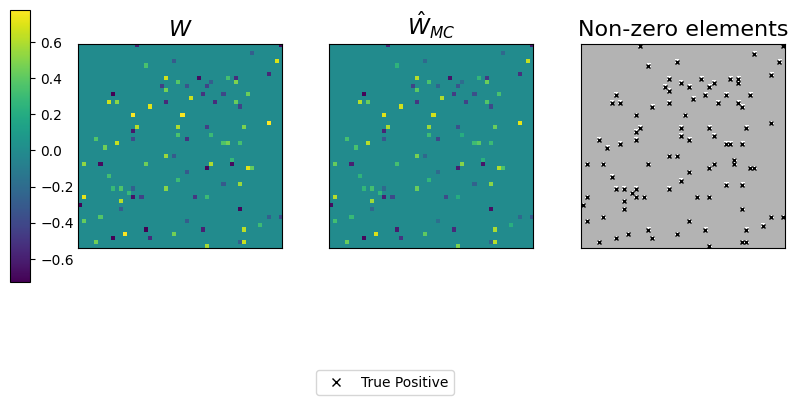

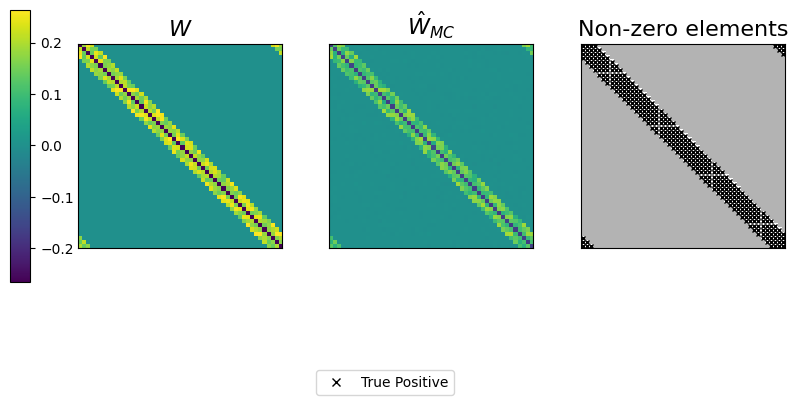

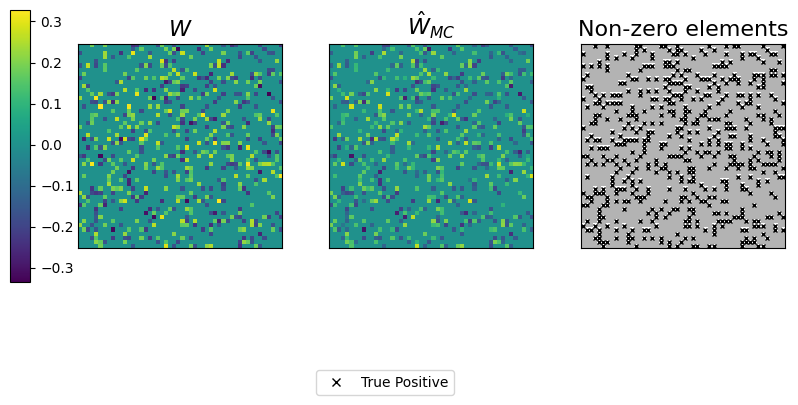

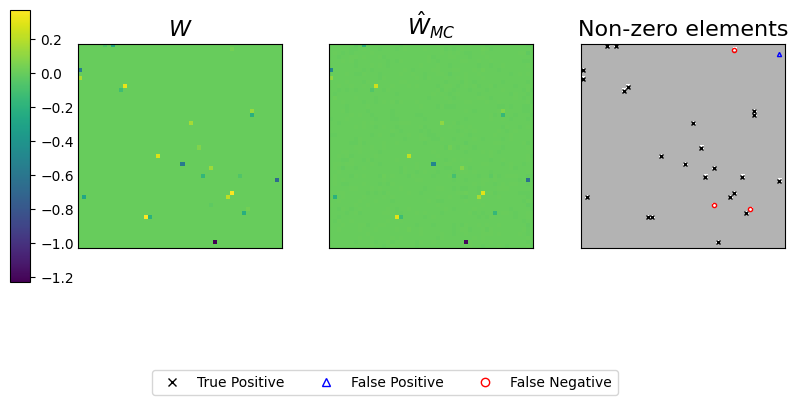

In [47]:
from scipy.stats import mode
import matplotlib.pyplot as plt

def plot_triple_matrix_comparison_mean_mode(trues, preds, fsavepath):

    true_W = np.mean(trues, axis=0)
    pred_W = np.mean(preds, axis=0)

    mode_true_W = np.median(trues, axis=0)
    mode_pred_W = np.median(preds, axis=0)

    fig = plt.figure(figsize=(10, 4))
    gs = fig.add_gridspec(1, 4, width_ratios=[0.1, 1, 1, 1], wspace=0.3)
    
    cax = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3])
    
    # Find global min and max for consistent color scaling
    vmin = min(true_W.min(), pred_W.min())
    vmax = max(true_W.max(), pred_W.max())
    
    # Plot true_W
    im1 = ax1.imshow(true_W, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('${W}$', fontsize=16, fontweight='bold')
    
    # Plot pred_W
    im2 = ax2.imshow(pred_W, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('${\hat{W}_{MC}}$', fontsize=16, fontweight='bold')
    
    # Create a base matrix with grey for zeros and white for true non-zeros
    true_W_binary = mode_true_W != 0
    pred_W_binary = mode_pred_W != 0
    base_matrix = np.where(true_W_binary, 1, 0.7)
    
    # Plot the base matrix
    ax3.imshow(base_matrix, cmap='gray', vmin=0, vmax=1)
    ax3.set_title('Non-zero elements', fontsize=16)
    
    # Initialize counters for each case
    true_positive = false_positive = false_negative = 0
    
    # Add marks for different cases
    for i in range(true_W_binary.shape[0]):
        for j in range(true_W_binary.shape[1]):
            if pred_W_binary[i, j]:
                if true_W_binary[i, j]:
                    # True positive
                    ax3.plot(j, i, 'kx', markersize=3)
                    true_positive += 1
                else:
                    # False positive
                    ax3.plot(j, i, 'b^', markersize=3, markerfacecolor='none')
                    false_positive += 1
            elif true_W_binary[i, j]:
                # False negative
                ax3.plot(j, i, 'ro', markersize=3, markerfacecolor='none')
                false_negative += 1
    
    # Remove ticks and add grid for all plots
    for ax in [ax1, ax2, ax3]:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axisbelow(True)
        ax.grid(color='black', linestyle='-', linewidth=0.5)
    
    # Add vertical colorbar on the left
    plt.colorbar(im1, cax=cax)
    
    # Add legend underneath the plot, only for cases that occur
    legend_elements = []
    if true_positive > 0:
        legend_elements.append(plt.Line2D([0], [0], marker='x', color='k', label='True Positive',
                                          markersize=6, linestyle='None'))
    if false_positive > 0:
        legend_elements.append(plt.Line2D([0], [0], marker='^', color='b', label='False Positive',
                                          markersize=6, linestyle='None', markerfacecolor='none'))
    if false_negative > 0:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='r', label='False Negative',
                                          markersize=6, markerfacecolor='none', linestyle='None'))
    
    if legend_elements:  # Only add legend if there are elements to show
        fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), bbox_to_anchor=(0.5, -0.1))
        plt.subplots_adjust(bottom=0.2)  # Make room for the legend
    
    plt.tight_layout()
    # save the figure and the legends as a .svg file
    plt.savefig(fsavepath, bbox_inches='tight')
    plt.show()

for key in matrices.keys():
    graph = key[0]
    matrixs = matrices[key]
    trues = []
    preds = []
    for i, (true_W, pred_W) in enumerate(matrixs):
        trues.append(true_W)
        preds.append(pred_W)

    trues = np.array(trues)
    preds = np.array(preds)

    # most common non zero values
    most_common_nzv = mode((preds != 0).astype(int), axis=0).mode
    most_common_zvs = mode((preds == 0).astype(int), axis=0).mode

    mean_true = np.mean(trues, axis=0)
    mean_pred = np.mean(preds, axis=0)
    plot_triple_matrix_comparison_mean_mode(trues, preds, 'figures/290924_matrix_%s.svg' % (graph))

In [ ]:
df_tirso = split_by_algorithm(walk_sweep_dirs(sweep_dir_tirso))
df_tiso = split_by_algorithm(walk_sweep_dirs(sweep_dir_tiso))

tiso_mean = df_tiso.groupby(by=['graph', 'N']).median(numeric_only=True)
tiso_std = df_tiso.groupby(by=['graph', 'N']).quantile(0.75, numeric_only=True) - df_tiso.groupby(by=['graph', 'N']).quantile(0.25, numeric_only=True)
tirso_mean = df_tirso.groupby(by=['graph', 'N']).median(numeric_only=True)
tirso_std = df_tirso.groupby(by=['graph', 'N']).quantile(0.75, numeric_only=True) - df_tirso.groupby(by=['graph', 'N']).quantile(0.25, numeric_only=True)

tiso_N50 = tiso_mean.loc[(slice(None), N), :]
tirso_N50 = tirso_mean.loc[(slice(None), N), :]

# append +/- std to the mean
tiso_N50 = tiso_N50.join(tiso_std.loc[(slice(None), N), :], rsuffix='_std')
tirso_N50 = tirso_N50.join(tirso_std.loc[(slice(None), N), :], rsuffix='_std')

# Apply the function to each cell in the DataFrame
for df in [tiso_N50, tirso_N50]:
    for col in df.columns:
        if col.endswith('_std'):
            continue
        std_col = col + '_std'
        df[col] = df.apply(lambda row: format_mean_std(row[col], row[std_col]), axis=1)
        df.drop(columns=[std_col], inplace=True)

# add algorithm column
tiso_N50['algorithm'] = 'TISO'
tirso_N50['algorithm'] = 'TIRSO'

# remove N from index
tiso_N50.index = tiso_N50.index.droplevel('N')
tirso_N50.index = tirso_N50.index.droplevel('N')

# merge all dfs
df_main_res = pd.concat([adacgp_N50, tiso_N50, tirso_N50], axis=0)

# drop the 'nmse_pred_from_h' column
# order by index
df_main_res = df_main_res.drop(columns=['pce'])
df_main_res = df_main_res.sort_values(by=['graph', 'nmse_pred', 'algorithm'], ascending=[True, False, False])

# convert to latex
df_main_res.to_latex('tables/260924_main_results_table_N%s_%s.tex' % (N, best_error), escape=False)

In [59]:
tirso_N50

,nmse_pred,nmse_w,pce,p_miss,p_false_alarm,algorithm
graph,,,,,,
ER,0.68 $\pm$ 0.02,1.07 $\pm$ 0.01,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,1.00 $\pm$ 0.00,TIRSO
KR,0.73 $\pm$ 0.04,0.79 $\pm$ 0.02,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,1.00 $\pm$ 0.00,TIRSO
RANDOM,0.68 $\pm$ 0.01,1.07 $\pm$ 0.00,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,1.00 $\pm$ 0.00,TIRSO
SBM,0.88 $\pm$ 0.02,1.46 $\pm$ 0.09,1.00 $\pm$ 0.00,0.00 $\pm$ 0.00,1.00 $\pm$ 0.00,TIRSO


## LaTeX table reformatted

In [64]:
# Process AdaCGP data
adacgp_alternate_mean = df_alternate.groupby(['graph', 'N', 'use_path_1']).median(numeric_only=True)
adacgp_alternate_std = df_alternate.groupby(['graph', 'N', 'use_path_1']).quantile(0.75, numeric_only=True) - df_alternate.groupby(['graph', 'N', 'use_path_1']).quantile(0.25, numeric_only=True)
adacgp_not_alternate_mean = df_not_alternate.groupby(['graph', 'N', 'use_path_1']).median(numeric_only=True)
adacgp_not_alternate_std = df_not_alternate.groupby(['graph', 'N', 'use_path_1']).quantile(0.75, numeric_only=True) - df_not_alternate.groupby(['graph', 'N', 'use_path_1']).quantile(0.25, numeric_only=True)

# Process TISO and TIRSO data
df_tirso = split_by_algorithm(walk_sweep_dirs(sweep_dir_tirso))
df_tiso = split_by_algorithm(walk_sweep_dirs(sweep_dir_tiso))

tiso_mean = df_tiso.groupby(by=['graph', 'N']).median(numeric_only=True)
tiso_std = df_tiso.groupby(by=['graph', 'N']).quantile(0.75, numeric_only=True) - df_tiso.groupby(by=['graph', 'N']).quantile(0.25, numeric_only=True)
tirso_mean = df_tirso.groupby(by=['graph', 'N']).median(numeric_only=True)
tirso_std = df_tirso.groupby(by=['graph', 'N']).quantile(0.75, numeric_only=True) - df_tirso.groupby(by=['graph', 'N']).quantile(0.25, numeric_only=True)

# Define compact formatting function for all data
def format_compact(mean, std):
    """Format mean and std as mean±std with tiny std"""
    # Round to 2 decimal places
    mean_rounded = round(float(mean), 2)
    std_rounded = round(float(std), 2)
    
    # Format with the standard as tiny text
    return f"{mean_rounded}{{\\tiny$\\pm${std_rounded}}}"

# Process AdaCGP data
def split_alternate(df):
    split = split_by_algorithm(df.reset_index())
    split = split[split['algorithm'] == 'alg2']
    split['algorithm'] = 'alg3'
    return split

def split_not_alternate(df):
    split = split_by_algorithm(df.reset_index())
    return split

split_alternate_mean = split_alternate(adacgp_alternate_mean)
split_alternate_std = split_alternate(adacgp_alternate_std)

split_not_alternate_mean = split_not_alternate(adacgp_not_alternate_mean)
split_not_alternate_std = split_not_alternate(adacgp_not_alternate_std)

# Join the split means and stds
split_mean = pd.concat([split_alternate_mean, split_not_alternate_mean])
split_std = pd.concat([split_alternate_std, split_not_alternate_std])

split_mean = split_mean.groupby(['graph', 'N', 'use_path_1', 'algorithm']).mean()
split_std = split_std.groupby(['graph', 'N', 'use_path_1', 'algorithm']).mean()

adacgp_N50_path1 = split_mean.loc[(slice(None), N, 'True', slice(None)), :]
adacgp_N50_path2 = split_mean.loc[(slice(None), N, 'False', slice(None)), :]

# Append +/- std to the mean for AdaCGP
adacgp_N50_path1 = adacgp_N50_path1.join(split_std.loc[(slice(None), N, 'True', slice(None)), :], rsuffix='_std')
adacgp_N50_path2 = adacgp_N50_path2.join(split_std.loc[(slice(None), N, 'False', slice(None)), :], rsuffix='_std')

# Process TISO/TIRSO data
tiso_N50 = tiso_mean.loc[(slice(None), N), :]
tirso_N50 = tirso_mean.loc[(slice(None), N), :]

# Append +/- std to the mean for TISO/TIRSO
tiso_N50 = tiso_N50.join(tiso_std.loc[(slice(None), N), :], rsuffix='_std')
tirso_N50 = tirso_N50.join(tirso_std.loc[(slice(None), N), :], rsuffix='_std')

# Apply the formatting function to all datasets
for df in [adacgp_N50_path1, adacgp_N50_path2, tiso_N50, tirso_N50]:
    for col in df.columns:
        if col.endswith('_std'):
            continue
        std_col = col + '_std'
        df[col] = df.apply(lambda row: format_compact(row[col], row[std_col]), axis=1)
        df.drop(columns=[std_col], inplace=True)

# Remove 'use_path_1' from index
adacgp_N50_path1.index = adacgp_N50_path1.index.droplevel('use_path_1')
adacgp_N50_path2.index = adacgp_N50_path2.index.droplevel('use_path_1')

# Drop N from index
adacgp_N50_path1.index = adacgp_N50_path1.index.droplevel('N')
adacgp_N50_path2.index = adacgp_N50_path2.index.droplevel('N')
tiso_N50.index = tiso_N50.index.droplevel('N')
tirso_N50.index = tirso_N50.index.droplevel('N')

# Rename algorithms
name_changes = {'alg1': 'AdaCGP (standard)', 'alg2': 'AdaCGP (w/ debias)', 'alg3': 'AdaCGP (w/ alt. debias)'}
adacgp_N50_path1.index = adacgp_N50_path1.index.set_levels(adacgp_N50_path1.index.levels[-1].map(name_changes), level=-1)
adacgp_N50_path2.index = adacgp_N50_path2.index.set_levels(adacgp_N50_path2.index.levels[-1].map(name_changes), level=-1)

name_changes_path_1 = {'AdaCGP (standard)': 'AdaCGP-P1', 'AdaCGP (w/ debias)': 'AdaCGP-P1-DB', 'AdaCGP (w/ alt. debias)': 'AdaCGP-P1-ADB'}
name_changes_path_2 = {'AdaCGP (standard)': 'AdaCGP-P2', 'AdaCGP (w/ debias)': 'AdaCGP-P2-DB', 'AdaCGP (w/ alt. debias)': 'AdaCGP-P2-ADB'}
adacgp_N50_path1.index = adacgp_N50_path1.index.set_levels(adacgp_N50_path1.index.levels[-1].map(name_changes_path_1), level=-1)
adacgp_N50_path2.index = adacgp_N50_path2.index.set_levels(adacgp_N50_path2.index.levels[-1].map(name_changes_path_2), level=-1)

# Make the algorithm index a column for all datasets
adacgp_N50_path1.reset_index(level=-1, inplace=True)
adacgp_N50_path2.reset_index(level=-1, inplace=True)

# Add algorithm column to TISO/TIRSO
tiso_N50['algorithm'] = 'TISO'
tirso_N50['algorithm'] = 'TIRSO'

# Merge all dataframes
df_main_res = pd.concat([adacgp_N50_path1, adacgp_N50_path2, tiso_N50, tirso_N50], axis=0)

# Drop unnecessary columns
if 'pce' in df_main_res.columns:
    df_main_res = df_main_res.drop(columns=['pce'])

# Keep only the metrics we want and reorder
metrics_to_keep = ['nmse_pred', 'nmse_w', 'p_miss', 'p_false_alarm']
available_metrics = [m for m in metrics_to_keep if m in df_main_res.columns]

# Create the new table in the format similar to the reference
with open('tables/graph_estimation_results.tex', 'w') as f:
    # Table header - note the f-string instead of % formatting
    f.write(f"""\\begin{{table}}[htbp]
\\centering
\\caption{{Comparison of Graph Topology Estimation Algorithms for $N={N}$}}
\\label{{tab:graph_estimation}}
\\setlength{{\\tabcolsep}}{{4pt}}
\\small
\\begin{{tabular}}{{l|l|cccccccc}}
\\toprule
 & Metric """)
    
    # Add algorithm names as column headers (shortened to save space)
    algorithms = ['AdaCGP-P1', 'AdaCGP-P1-DB', 'AdaCGP-P1-ADB', 
                  'AdaCGP-P2', 'AdaCGP-P2-DB', 'AdaCGP-P2-ADB', 
                  'TISO', 'TIRSO']
    
    for alg in algorithms:
        f.write(f"& {alg} ")
    f.write("\\\\\n\\midrule\n")
    
    # Get sorted graph types
    graph_types = sorted(df_main_res.index.unique())
    
    # Metric display names
    metric_names = {
        'nmse_pred': 'NMSE',
        'nmse_w': 'NMSE$_w$',
        'p_miss': 'P$_{miss}$',
        'p_false_alarm': 'P$_{FA}$'
    }
    
    # For each graph type, create multirow with metrics
    for i, graph in enumerate(graph_types):
        # Create a multirow for the graph name
        num_metrics = len(available_metrics)
        graph_name = graph.replace('_', '-')
        
        # Write the graph name in multirow
        f.write(f"\\multirow{{{num_metrics}}}{{*}}{{\\rotatebox{{90}}{{{graph_name}}}}} ")
        
        # Add each metric for this graph
        for j, metric in enumerate(available_metrics):
            metric_display = metric_names.get(metric, metric)
            
            # Only add metric name in the first row of the multirow
            if j == 0:
                f.write(f"& {metric_display} ")
            else:
                f.write(f"& {metric_display} ")
            
            # Add values for each algorithm
            for alg in algorithms:
                try:
                    # Get data for this graph, metric, and algorithm
                    value = df_main_res.loc[graph]
                    value = value[value['algorithm'] == alg][metric].values[0]
                    f.write(f"& {value} ")
                except:
                    f.write("& --- ")
            
            f.write("\\\\")
            
            # Add cmidrule after each graph type except the last
            if j == num_metrics - 1 and i < len(graph_types) - 1:
                f.write("\n\\midrule")
            f.write("\n")
    
    # Table footer
    f.write("\\bottomrule\n\\end{tabular}\n\\end{table}")

print("Formatted LaTeX table generated at tables/graph_estimation_results.tex")

Formatted LaTeX table generated at tables/graph_estimation_results.tex


In [ ]:
def generate_improved_table(df_main_res, N, output_file='tables/improved_graph_estimation.tex'):
    """
    Generate a professionally formatted LaTeX table with graph topology results.
    
    Parameters:
    -----------
    df_main_res : DataFrame
        The processed results dataframe
    N : int or str
        The N value for the table caption
    output_file : str
        Path to save the LaTeX table
    """
    import pandas as pd
    
    # Define metrics and their display names (arrows removed)
    metrics = ['nmse_pred', 'nmse_w', 'p_miss', 'p_false_alarm']
    metric_names = {
        'nmse_pred': 'NMSE',
        'nmse_w': 'NMSE$(\\mathbf{W})$',
        'p_miss': 'P$_{M}$',
        'p_false_alarm': 'P$_{FA}$'
    }
    
    # Algorithm display names (shorter for table)
    alg_display = {
        'AdaCGP-P1-DB': 'P1 + DB',
        'AdaCGP-P1-ADB': 'P1 + ADB',
        'AdaCGP-P2-DB': 'P2 + DB',
        'AdaCGP-P2-ADB': 'P2 + ADB',
        'TISO': 'TISO',
        'TIRSO': 'TIRSO'
    }
    
    # Graph type display names
    graph_display = {
        'ER': 'Erdos-Renyi',
        'KR': 'K-Regular',
        'RANDOM': 'Random',
        'SBM': 'Stochastic Block Model'
    }
    
    # New order for graph types
    graph_types = ['RANDOM', 'ER', 'KR', 'SBM']
    
    # Ordered list of algorithms to display (in requested order)
    algorithms = ['TIRSO', 'TISO', 'AdaCGP-P2-ADB', 'AdaCGP-P2-DB', 'AdaCGP-P1-ADB', 'AdaCGP-P1-DB']
    
    # Simplify uncertainty values with consistent decimal places
    def clean_value(value_str):
        # Handle NaN or missing values
        if value_str == "---" or pd.isna(value_str):
            return "---"
            
        # Extract the mean and std parts
        if "{\\tiny$\\pm$" in value_str:
            parts = value_str.split("{\\tiny$\\pm$")
            mean_str = parts[0]
            std_str = parts[1].replace("}", "")
            
            # Convert to float for processing
            mean = float(mean_str)
            std = float(std_str)
            
            # Always use 2 decimal places for consistency
            return "{:.2f}".format(mean) + "{\\tiny$\\pm$" + "{:.2f}".format(std) + "}"
        else:
            # If there's no uncertainty, just return the value with 2 decimal places
            try:
                return "{:.2f}".format(float(value_str))
            except:
                return value_str
    
    # Function to find best and second best values
    def find_best_and_second(data, metric):
        if data.empty:
            return {}, {}
            
        sorted_data = data.sort_values(by=metric)
        if len(sorted_data) >= 1:
            best = sorted_data.iloc[0]
            best_val = best[metric]
            best_alg = best['algorithm']
        else:
            best_val, best_alg = None, None
            
        if len(sorted_data) >= 2:
            second_best = sorted_data.iloc[1]
            second_best_val = second_best[metric]
            second_best_alg = second_best['algorithm']
        else:
            second_best_val, second_best_alg = None, None
            
        return {best_alg: best_val}, {second_best_alg: second_best_val}
    
    # Get best and second best for each graph and metric
    best_values = {}
    second_best_values = {}
    
    for graph in graph_types:
        best_values[graph] = {}
        second_best_values[graph] = {}
        graph_data = df_main_res.loc[graph].reset_index(drop=True)
        
        for metric in metrics:
            best, second = find_best_and_second(graph_data, metric)
            best_values[graph][metric] = best
            second_best_values[graph][metric] = second
    
    # Generate LaTeX table
    with open(output_file, 'w') as f:
        # Write table header with improved formatting
        header = "\\begin{table*}[t]\n"
        header += "\\centering\n"
        header += "\\caption{Comparison of graph topology estimation algorithms for $N = " + str(N) + "$. Lower values are better for all metrics.}\n"
        header += "\\label{tab:graph_estimation}\n"
        header += "\\setlength{\\tabcolsep}{6pt}  % Increased horizontal spacing\n"
        header += "\\setlength{\\aboverulesep}{0pt}\n"
        header += "\\setlength{\\belowrulesep}{0pt}\n"
        header += "\\renewcommand{\\arraystretch}{1.15}\n"
        f.write(header)
        
        # Define column structure with spacer columns for better separation
        column_count = len(metrics)
        column_def = "@{}l" + "".join(["c!{\\hspace{1em}}" for _ in range(column_count-1)]) + "c" + "!{\\hspace{2em}}" + "".join(["c!{\\hspace{1em}}" for _ in range(column_count-1)]) + "c" + "@{}}"
        f.write("\\begin{tabular}{" + column_def + "\n")
        f.write("\\toprule\n")
        
        # Create header row for the first two graph types (RANDOM and ER)
        f.write("& \\multicolumn{" + str(column_count) + "}{c}{" + graph_display['RANDOM'] + "} ")
        f.write("& \\multicolumn{" + str(column_count) + "}{c}{" + graph_display['ER'] + "} \\\\\n")
        f.write("\\cmidrule(lr){2-" + str(column_count+1) + "} \\cmidrule(lr){" + str(column_count+2) + "-" + str(2*column_count+1) + "}\n")
        
        # Add metric names to column headers
        f.write("Algorithm")
        for _ in range(2):  # For both Random and ER
            for metric in metrics:
                f.write(" & " + metric_names[metric])
        f.write(" \\\\\n")
        f.write("\\midrule\n")
        
        # Add data for the first section (RANDOM and ER)
        for alg in algorithms:
            row_text = alg_display.get(alg, alg)
            
            # Add values for RANDOM graph
            graph = 'RANDOM'
            random_data = df_main_res.loc[graph].reset_index(drop=True)
            random_alg_data = random_data[random_data['algorithm'] == alg]
            
            for i, metric in enumerate(metrics):
                if not random_alg_data.empty and metric in random_alg_data.columns:
                    value = clean_value(str(random_alg_data[metric].values[0]))
                    
                    # Check if best or second best
                    best_alg = list(best_values[graph][metric].keys())[0] if best_values[graph][metric] else None
                    second_best_alg = list(second_best_values[graph][metric].keys())[0] if second_best_values[graph][metric] else None
                    
                    # if alg == best_alg:
                    #     row_text += " & \\textbf{" + value + "}"
                    # elif alg == second_best_alg:
                    #     row_text += " & \\underline{" + value + "}"
                    # else:
                    row_text += " & " + value
                else:
                    row_text += " & ---"
            
            # Add values for ER graph
            graph = 'ER'
            er_data = df_main_res.loc[graph].reset_index(drop=True)
            er_alg_data = er_data[er_data['algorithm'] == alg]
            
            for i, metric in enumerate(metrics):
                if not er_alg_data.empty and metric in er_alg_data.columns:
                    value = clean_value(str(er_alg_data[metric].values[0]))
                    
                    # Check if best or second best
                    best_alg = list(best_values[graph][metric].keys())[0] if best_values[graph][metric] else None
                    second_best_alg = list(second_best_values[graph][metric].keys())[0] if second_best_values[graph][metric] else None
                    
                    # if alg == best_alg:
                    #     row_text += " & \\textbf{" + value + "}"
                    # elif alg == second_best_alg:
                    #     row_text += " & \\underline{" + value + "}"
                    # else:
                    row_text += " & " + value
                else:
                    row_text += " & ---"
            
            row_text += " \\\\\n"
            f.write(row_text)
        
        # Add vertical space between the two graph sections
        f.write("\\midrule\n")
        f.write("\\addlinespace[1em]  % Added vertical space\n")
        
        # Create header row for the second two graph types (KR and SBM)
        f.write("& \\multicolumn{" + str(column_count) + "}{c}{" + graph_display['KR'] + "} ")
        f.write("& \\multicolumn{" + str(column_count) + "}{c}{" + graph_display['SBM'] + "} \\\\\n")
        f.write("\\cmidrule(lr){2-" + str(column_count+1) + "} \\cmidrule(lr){" + str(column_count+2) + "-" + str(2*column_count+1) + "}\n")
        
        # Add metric names to column headers for KR and SBM
        f.write("Algorithm")
        for _ in range(2):  # For both KR and SBM
            for metric in metrics:
                f.write(" & " + metric_names[metric])
        f.write(" \\\\\n")
        f.write("\\midrule\n")
        
        # Add data for the second section (KR and SBM)
        for alg in algorithms:
            row_text = alg_display.get(alg, alg)
            
            # Add values for KR graph
            graph = 'KR'
            kr_data = df_main_res.loc[graph].reset_index(drop=True)
            kr_alg_data = kr_data[kr_data['algorithm'] == alg]
            
            for i, metric in enumerate(metrics):
                if not kr_alg_data.empty and metric in kr_alg_data.columns:
                    value = clean_value(str(kr_alg_data[metric].values[0]))
                    
                    # Check if best or second best
                    best_alg = list(best_values[graph][metric].keys())[0] if best_values[graph][metric] else None
                    second_best_alg = list(second_best_values[graph][metric].keys())[0] if second_best_values[graph][metric] else None
                    
                    # if alg == best_alg:
                    #     row_text += " & \\textbf{" + value + "}"
                    # elif alg == second_best_alg:
                    #     row_text += " & \\underline{" + value + "}"
                    # else:
                    row_text += " & " + value
                else:
                    row_text += " & ---"
            
            # Add values for SBM graph
            graph = 'SBM'
            sbm_data = df_main_res.loc[graph].reset_index(drop=True)
            sbm_alg_data = sbm_data[sbm_data['algorithm'] == alg]
            
            for i, metric in enumerate(metrics):
                if not sbm_alg_data.empty and metric in sbm_alg_data.columns:
                    value = clean_value(str(sbm_alg_data[metric].values[0]))
                    
                    # Check if best or second best
                    best_alg = list(best_values[graph][metric].keys())[0] if best_values[graph][metric] else None
                    second_best_alg = list(second_best_values[graph][metric].keys())[0] if second_best_values[graph][metric] else None
                    
                    # if alg == best_alg:
                    #     row_text += " & \\textbf{" + value + "}"
                    # elif alg == second_best_alg:
                    #     row_text += " & \\underline{" + value + "}"
                    # else:
                    row_text += " & " + value
                else:
                    row_text += " & ---"
            
            row_text += " \\\\\n"
            f.write(row_text)
        
        # Close the tabular environment
        f.write("\\bottomrule\n")
        f.write("\\end{tabular}\n")
        f.write("\\end{table*}")
    
    print(f"Improved LaTeX table generated at {output_file}")
    return output_file

generate_improved_table(df_main_res, N)

Improved LaTeX table generated at tables/improved_graph_estimation.tex


'tables/improved_graph_estimation.tex'

In [295]:
best_adacgp = df_adacgp.groupby(by=['graph', 'N', 'use_path_1', 'alternate']).apply(lambda x: x.sort_values(by=['nmse_pred_alg2'], ascending=[True]).head(1))


/home/alex/miniconda3/envs/cgp/lib/python3.11/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


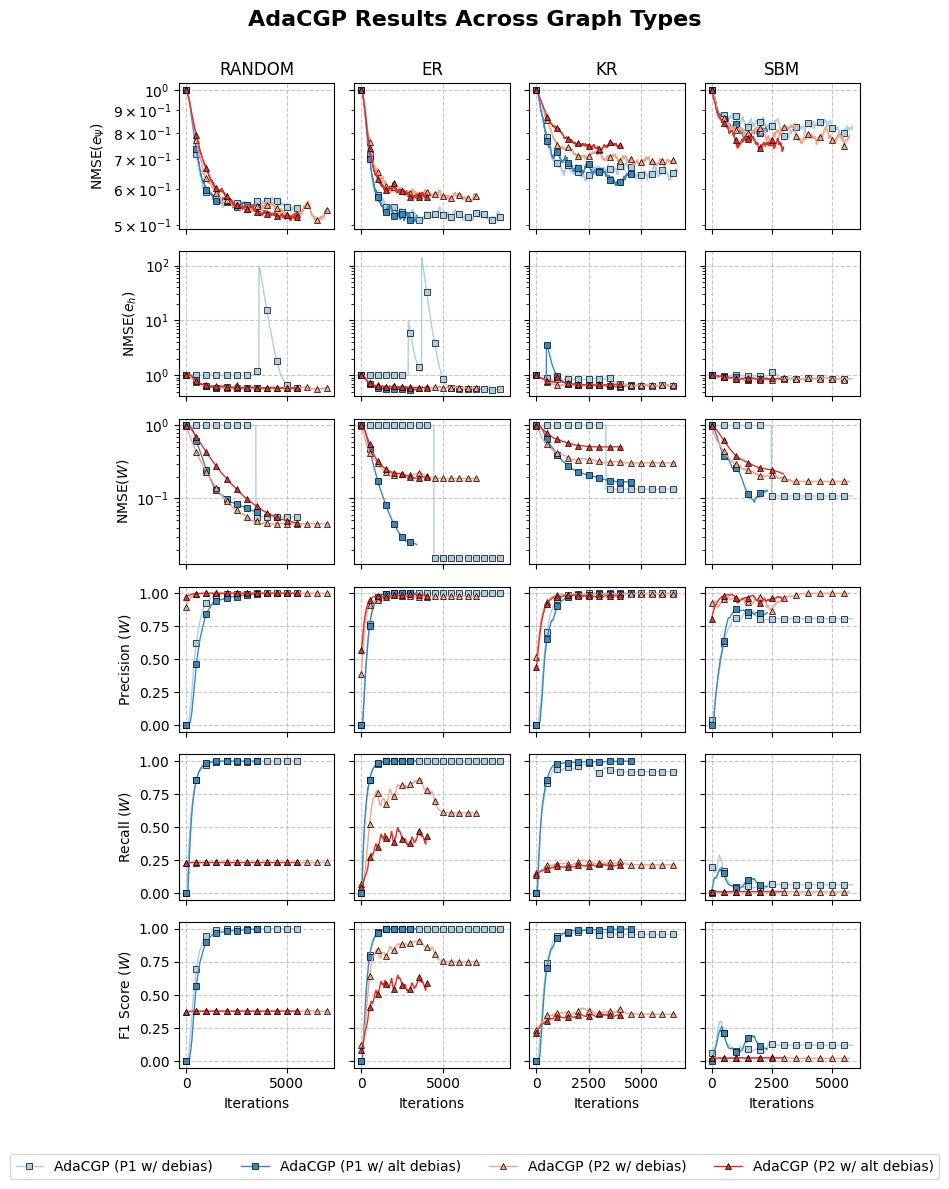

In [304]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_combined_adacgp_results(best_adacgp, sweep_dir_adacgp):
    n_rows = 4
    n_cols = 6
    fig, axs = plt.subplots(n_cols, n_rows, figsize=(2*n_rows, 2*n_cols), sharex='col', sharey='row')
    graph_types = ['RANDOM', 'ER', 'KR', 'SBM']
    metrics = ['NMSE$(e_\Psi)$', 'NMSE$(e_h)$', 'NMSE$(W)$', 'Precision ($W$)', 'Recall ($W$)', 'F1 Score ($W$)']
    
    cmap_blue = plt.get_cmap('Blues')
    cmap_red = plt.get_cmap('Reds')
    
    scenarios = [
        (False, True, 'AdaCGP (P1 w/ debias)', 's', cmap_blue((20+10) / 90)),
        (True, True, 'AdaCGP (P1 w/ alt debias)', 's', cmap_blue((50+10) / 90)),
        (False, False, 'AdaCGP (P2 w/ debias)', '^', cmap_red((20+10) / 90)),
        (True, False, 'AdaCGP (P2 w/ alt debias)', '^', cmap_red((50+10) / 90))
    ]
    
    for col, graph in enumerate(graph_types):
        for row, metric in enumerate(metrics):
            ax = axs[row, col]
            if row in [3, 4, 5]:
                pass
            else:
                ax.set_yscale('log')
            ax.grid(True, which='major', linestyle='--', alpha=0.7)
            
            if row == n_cols-1:  # Bottom row
                ax.set_xlabel('Iterations')
            if col == 0:  # Left column
                ax.set_ylabel(metric)
            if row == 0:  # Top row
                ax.set_title(graph)
    
    for graph in graph_types:
        col = graph_types.index(graph)
        
        for alternate, use_path_1, label, marker, color in scenarios:
            try:
                subdf = best_adacgp.loc[(graph, slice(None), str(use_path_1), str(alternate)), :]
            except Exception as e:
                print(f"Error processing {graph} with use_path_1={use_path_1}, alternate={alternate}: {e}")
                continue
            
            for i, (_, row_data) in enumerate(subdf.iterrows()):
                row_results_path = os.path.join(sweep_dir_adacgp, row_data['subdir'])
                with open(os.path.join(row_results_path, 'results.pkl'), 'rb') as f:
                    results = pickle.load(f)
                
                N = int(row_data['N'])
                if N > 250:
                    continue
                
                linestyle = {50: '-', 100: '--', 250: '-.'}[N]
                
                plot_data = [
                    results['pred_error_recursive_moving_average'][2:],
                    results['pred_error_recursive_moving_average_h'][2:],
                    results['w_error'][2:],
                    results['recall'][2:],
                    results['precision'][2:],
                    results['f1'][2:],
                ]
                
                for row, data in enumerate(plot_data):
                    ax = axs[row, col]
                    if alternate and row == 2:
                        # here we plot the moving average of the data but just for alternating values where debiasing is used
                        switch_algorithm = np.array([(t % 2 == 0) for t in range(0, len(results['w_error']))])[2:]
                        data = np.where(switch_algorithm, data, np.nan)
                        data = pd.Series(data).fillna(method='ffill').values

                        data = moving_average(data, alpha=0.005)
                    if row in [3, 4, 5]:
                        data = moving_average(data, alpha=0.005)
                    ax.plot(data, label=f"{label}", linestyle=linestyle, color=color, marker=marker,
                            markevery=500, markersize=4, markeredgecolor='black', markeredgewidth=0.5, linewidth=1)
                
                debiasing_transition = get_debiasing_transition(results, alternate)
                if debiasing_transition is not None:
                    for row in range(n_rows):
                        axs[row, col].axvline(debiasing_transition, len(data), alpha=0.1, color=color)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    fig.suptitle("AdaCGP Results Across Graph Types", fontsize=16, fontweight='bold')
    
    # Create a single legend for the entire figure
    handles, labels = axs[0, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure)
    
    plt.savefig('figures/AdaCGP_combined_results.svg', bbox_inches='tight', dpi=300)
    plt.show()

def moving_average(data, alpha=0.005):
    ma = [data[0]]
    for i in range(1, len(data)):
        ma_t = alpha * data[i] + (1 - alpha) * ma[-1]
        ma.append(ma_t)
    return np.array(ma)

def get_debiasing_transition(results, alternate):
    if alternate:
        return None
    debiasing_region = np.array(results['first_alg_converged_status']).astype(int)
    debias_inds = np.where(debiasing_region == 1)[0]
    return None if len(debias_inds) == 0 else debias_inds[0]

# Usage:
plot_combined_adacgp_results(best_adacgp, sweep_dir_adacgp)

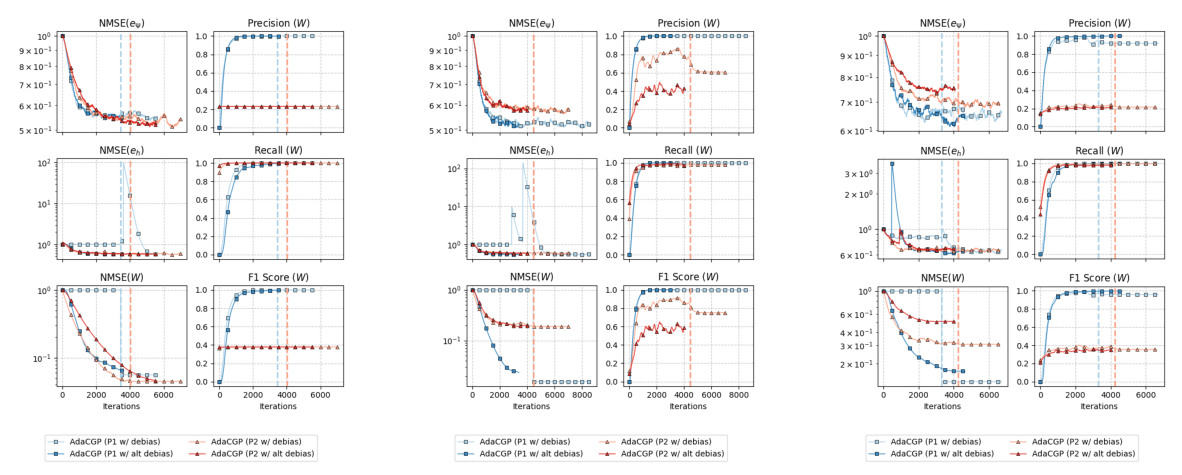

In [309]:
def plot_combined_adacgp_results(best_adacgp, sweep_dir_adacgp):
    n_rows = 3
    n_cols = 2
    graph_types = ['RANDOM', 'ER', 'KR']
    metrics = ['NMSE$(e_\Psi)$', 'Precision ($W$)', 'NMSE$(e_h)$', 'Recall ($W$)', 'NMSE$(W)$', 'F1 Score ($W$)']
    
    cmap_blue = plt.get_cmap('Blues')
    cmap_red = plt.get_cmap('Reds')
    
    scenarios = [
        (False, True, 'AdaCGP (P1 w/ debias)', 's', cmap_blue((20+10) / 90)),
        (True, True, 'AdaCGP (P1 w/ alt debias)', 's', cmap_blue((50+10) / 90)),
        (False, False, 'AdaCGP (P2 w/ debias)', '^', cmap_red((20+10) / 90)),
        (True, False, 'AdaCGP (P2 w/ alt debias)', '^', cmap_red((50+10) / 90))
    ]
    
    # Create a figure for all graph types
    fig = plt.figure(figsize=(5 * len(graph_types), 10))
    
    for graph_index, graph in enumerate(graph_types):
        # Create subplot for each graph type
        subplot = fig.add_subplot(1, len(graph_types), graph_index + 1)
        subplot_fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_rows, 4*n_cols), sharex=True)
        
        for row in range(n_rows):
            for col in range(n_cols):
                metric_index = row * n_cols + col
                if metric_index < len(metrics):
                    ax = axs[row, col]
                    metric = metrics[metric_index]
                    
                    if metric_index in [0, 2, 4]:
                        ax.set_yscale('log')
                    ax.grid(True, which='major', linestyle='--', alpha=0.7)
                    
                    if row == n_rows - 1:  # Bottom row
                        ax.set_xlabel('Iterations')
                    # if col == 0:  # Left column
                    #     ax.set_ylabel(metric)
                    # if row == 0 and col == 0:  # Top-left corner
                    #     ax.set_title(graph)
                    
                    for alternate, use_path_1, label, marker, color in scenarios:
                        try:
                            subdf = best_adacgp.loc[(graph, slice(None), str(use_path_1), str(alternate)), :]
                        except Exception as e:
                            print(f"Error processing {graph} with use_path_1={use_path_1}, alternate={alternate}: {e}")
                            continue
                        
                        for i, (_, row_data) in enumerate(subdf.iterrows()):
                            row_results_path = os.path.join(sweep_dir_adacgp, row_data['subdir'])
                            with open(os.path.join(row_results_path, 'results.pkl'), 'rb') as f:
                                results = pickle.load(f)
                            
                            N = int(row_data['N'])
                            if N > 250:
                                continue
                            
                            linestyle = {50: '-', 100: '--', 250: '-.'}[N]
                            
                            plot_data = [
                                results['pred_error_recursive_moving_average'][2:],
                                results['precision'][2:],
                                results['pred_error_recursive_moving_average_h'][2:],
                                results['recall'][2:],
                                results['w_error'][2:],
                                results['f1'][2:],
                            ][metric_index]
            
                            if alternate and metric_index == 4:
                                plot_data = moving_average(plot_data, alpha=0.005)
                            
                            if metric_index in [1, 3, 5]:
                                plot_data = moving_average(plot_data, alpha=0.005)
                            
                            ax.plot(plot_data, label=f"{label}", linestyle=linestyle, color=color, marker=marker,
                                    markevery=500, markersize=4, markeredgecolor='black', markeredgewidth=0.5, linewidth=1)
                            
                            debiasing_transition = get_debiasing_transition(results, alternate)
                            if debiasing_transition is not None:
                                ax.axvline(x=debiasing_transition, color=color, linestyle='--', linewidth=2)

                    ax.set_title(metric)
        
        subplot_fig.tight_layout(rect=[0, 0.1, 1, 1])
        # subplot_fig.suptitle(f"{graph} Graph Type", fontsize=16, fontweight='bold')
        
        # Create a legend for each subplot
        handles, labels = axs[0, 0].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        subplot_fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0), bbox_transform=subplot_fig.transFigure)
        
        # Save each subplot figure
        plt.savefig(f'figures/AdaCGP_results_{graph}.svg', bbox_inches='tight', dpi=300)
        
        # Add the subplot to the main figure
        subplot.imshow(subplot_fig.canvas.renderer._renderer)
        subplot.axis('off')
        
        plt.close(subplot_fig)
    
    # fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    # fig.suptitle("AdaCGP Results Across Graph Types", fontsize=20, fontweight='bold')
    
    plt.savefig('figures/AdaCGP_combined_results.svg', bbox_inches='tight', dpi=300)
    plt.show()

plot_combined_adacgp_results(best_adacgp, sweep_dir_adacgp)

In [235]:
best_adacgp

subdir  \
graph N  use_path_1 alternate                                                         
ER    50 False      False     73  nmse_pred_from_h_alg2/4/graph_ER/N_50/use_path...   
                    True      46  nmse_pred_from_h_alg2/20/graph_ER/N_50/use_pat...   
         True       False     75  nmse_pred_from_h_alg2/4/graph_ER/N_50/use_path...   
                    True      14  nmse_pred_from_h_alg2/7/graph_ER/N_50/use_path...   
KR    50 False      False     97  nmse_pred_from_h_alg2/17/graph_KR/N_50/use_pat...   
                    True      77  nmse_pred_from_h_alg2/9/graph_KR/N_50/use_path...   

                                 nmse_pred_from_h seed graph   N use_path_1  \
graph N  use_path_1 alternate                                                 
ER    50 False      False     73             alg2    4    ER  50      False   
                    True      46             alg2   20    ER  50      False   
         True       False     75             alg2    4    ER  50       True   
                    True      14             alg2    7    ER  50       True   
KR    50 False      False     97             alg2   17    KR  50      False   
                    True      77             alg2    9    KR  50      False   

                                 alternate  nmse_pred_alg1  \
graph N  use_path_1 alternate                                
ER    50 False      False     73     False        0.587196   
                    True      46      True        0.580587   
         True       False     75     False        0.523470   
                    True      14      True        0.522114   
KR    50 False      False     97     False        0.717045   
                    True      77      True        0.752830   

                                  nmse_pred_from_h_alg1  nmse_w_alg1  ...  \
graph N  use_path_1 alternate                                         ...   
ER    50 False      False     73               0.597934     0.206889  ...   
                    True      46               0.591472     0.193621  ...   
         True       False     75              31.245913     0.999995  ...   
                    True      14               0.554338     0.024487  ...   
KR    50 False      False     97               0.667197     0.341192  ...   
                    True      77               0.673656     0.509515  ...   

                                  nmse_pred_alg2  nmse_pred_from_h_alg2  \
graph N  use_path_1 alternate                                             
ER    50 False      False     73        0.576061               0.587839   
                    True      46        0.580587               0.591472   
         True       False     75        0.518393               0.550165   
                    True      14        0.522114               0.554338   
KR    50 False      False     97        0.693281               0.651824   
                    True      77        0.752830               0.673656   

                                  nmse_w_alg2  pce_alg2  p_miss_alg2  \
graph N  use_path_1 alternate                                          
ER    50 False      False     73     0.188045  0.978947     0.021053   
                    True      46     0.193621  0.985211     0.014789   
         True       False     75     0.015460  1.000000     0.000000   
                    True      14     0.024487  1.000000     0.000000   
KR    50 False      False     97     0.323704  1.000000     0.000000   
                    True      77     0.509515  0.978986     0.021014   

                                  p_false_alarm_alg2  p_miss_inverse  \
graph N  use_path_1 alternate                                          
ER    50 False      False     73            0.024948       47.499999   
                    True      46            0.056297       67.615657   
         True       False     75            0.000000        0.000000   
                    True      14            0.000000        0.000000   
KR    50 False      Fal

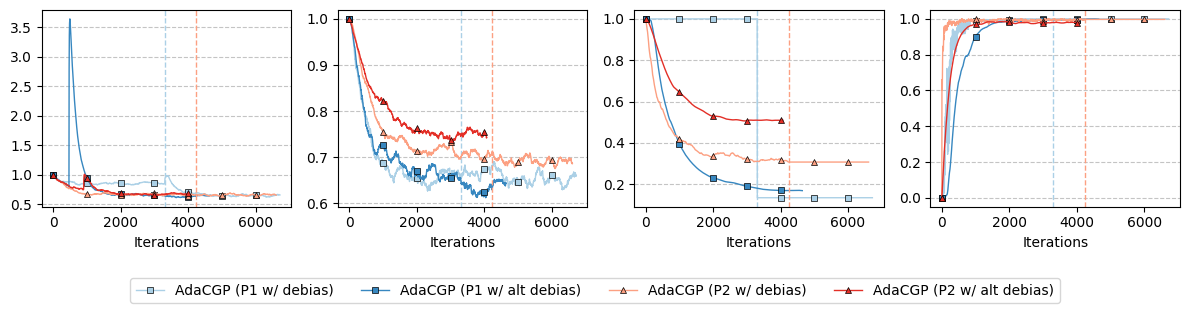

In [298]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter

def plot_random_graph_adacgp_results(best_adacgp, sweep_dir_adacgp, graph='ER'):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True)
    metrics = ['NMSE$(e_h)$', 'NMSE$(e_\Psi)$', 'NMSE$(W)$', 'Correct Edges [%]']
    
    cmap_blue = plt.get_cmap('Blues')
    cmap_red = plt.get_cmap('Reds')
    
    scenarios = [
        (False, True, 'AdaCGP (P1 w/ debias)', 's', cmap_blue((20+10) / 90)),
        (True, True, 'AdaCGP (P1 w/ alt debias)', 's', cmap_blue((50+10) / 90)),
        (False, False, 'AdaCGP (P2 w/ debias)', '^', cmap_red((20+10) / 90)),
        (True, False, 'AdaCGP (P2 w/ alt debias)', '^', cmap_red((50+10) / 90))
    ]
    
    for col, metric in enumerate(metrics):
        ax = axs[col]
        # ax.set_yscale('log')
        ax.yaxis.grid(True, alpha=0.75, linestyle='--', which='major')
        ax.set_xlabel('Iterations')
        # ax.set_ylabel(metric)
        # ax.yaxis.set_major_locator(LogLocator(numticks=6))
        # ax.yaxis.set_minor_locator(LogLocator(numticks=6, subs=(.2,.4,.6,.8)))
        # ax.yaxis.set_minor_formatter(NullFormatter())
        # ax.tick_params(which='both', length=4, width=1)
        # ax.tick_params(which='major', length=7)
    
    legend_elements = []
    
    for alternate, use_path_1, label, marker, color in scenarios:
        try:
            subdf = best_adacgp.loc[(graph, slice(None), str(use_path_1), str(alternate)), :]
        except Exception as e:
            print(f"Error processing {graph} graph with use_path_1={use_path_1}, alternate={alternate}: {e}")
            continue
        
        for i, (_, row_data) in enumerate(subdf.iterrows()):
            row_results_path = os.path.join(sweep_dir_adacgp, row_data['subdir'])
            with open(os.path.join(row_results_path, 'results.pkl'), 'rb') as f:
                results = pickle.load(f)
            
            N = int(row_data['N'])
            if N > 250:
                continue
            
            linestyle = {50: '-', 100: '--', 250: '-.'}[N]
            
            plot_data = [
                results['pred_error_recursive_moving_average_h'],
                results['pred_error_recursive_moving_average'],
                results['w_error'],
                [0] + results['recall'][1:]
            ]

            debiasing_transition = get_debiasing_transition(results, alternate)
            if debiasing_transition is not None:
                for col in range(4):
                    debias_line = axs[col].axvline(x=debiasing_transition, color=color, linestyle='--', linewidth=1, label=f"Debiasing")
                # legend_elements.append(debias_line)
    
            for col, data in enumerate(plot_data):
                ax = axs[col]
                if alternate and col in [2, 3]:
                    data = moving_average(data, alpha=0.005)
                line, = ax.plot(data, label=f"{label}", linestyle=linestyle, color=color, marker=marker,
                        markevery=1000, markersize=4, markeredgecolor='black', markeredgewidth=0.5, linewidth=1)
                
                if col == 0:  # Only add to legend once
                    legend_elements.append(line)
            
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    # fig.suptitle("AdaCGP Results for RANDOM Graph", fontsize=16, fontweight='bold')
    
    # Create a single legend for the entire figure
    labels = [f"{label}" for N in [50, 100, 250] for _, _, label, _, _ in scenarios]
    # labels += [f"{label} Debiasing" for _, _, label, _, _ in scenarios if not _[0]]  # Only for non-alternate scenarios
    fig.legend(legend_elements, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.1), bbox_transform=fig.transFigure)
    plt.savefig(f'figures/AdaCGP_{graph}_graph_results.svg', bbox_inches='tight', dpi=300)
    plt.show()

def moving_average(data, alpha=0.005):
    ma = [data[0]]
    for i in range(1, len(data)):
        ma_t = alpha * data[i] + (1 - alpha) * ma[-1]
        ma.append(ma_t)
    return np.array(ma)

def get_debiasing_transition(results, alternate):
    if alternate:
        return None
    debiasing_region = np.array(results['first_alg_converged_status']).astype(int)
    debias_inds = np.where(debiasing_region == 1)[0]
    return None if len(debias_inds) == 0 else debias_inds[0]

# Usage:
plot_random_graph_adacgp_results(best_adacgp, sweep_dir_adacgp, graph='KR')